In [2]:
#import des libraires nécessaires
import os
import numpy as np
import matplotlib.pyplot as plt
from brainspace.mesh.mesh_io import read_surface
from brainspace.plotting import plot_hemispheres
import pandas as pd
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency, f_oneway, pearsonr, zscore
import statsmodels.api as sm
import glob
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
import laBIBILaRORO as lbr
from importlib import reload
from itertools import combinations
from itertools import chain
import pingouin as pg
from IPython.display import Image
from skimage.util import montage 
from scipy.ndimage import binary_closing, binary_opening, generate_binary_structure
from brainstat.datasets import fetch_mask, fetch_template_surface, fetch_parcellation
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect
from nilearn import surface, datasets, plotting
from nilearn.image import smooth_img, threshold_img
from nilearn.plotting import plot_surf_stat_map
from nilearn.surface import vol_to_surf
import imageio
import nilearn

#import plotnine as p9
try :
    import nibabel as nib
except : 
    !pip install nibabel
    import nibabel as nib

from skimage.transform import rotate
try : 
    import openxyl
except : 
    ! pip install openpyxl
from matplotlib.backends.backend_pdf import PdfPages
#%matplotlib notebook
%matplotlib inline


La bibil à RORO loaded


In [3]:
glasser = fetch_parcellation("fsaverage5", "glasser", 360)
glasser_fslr32k = fetch_parcellation("fslr32k", "glasser", 360)

mask = fetch_mask("fsaverage5")
mask_fslr32k = fetch_mask("fslr32k")

fsaverage_nii = nilearn.datasets.fetch_surf_fsaverage()

pial_combined = fetch_template_surface("fsaverage5", join=True)
pial_combined_fslr32k = fetch_template_surface("fslr32k", join=True)

pial_left, pial_right = fetch_template_surface("fsaverage5",layer="pial",join=False)
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)

pial_left_fslr32k, pial_right_fslr32k = fetch_template_surface("fslr32k", join=False)
inflated_left_fslr32k,inflated_right_fslr32k = fetch_template_surface("fslr32k",layer="inflated", join=False)

vinflated_left_fslr32k,vinflated_right_fslr32k = fetch_template_surface("fslr32k",layer="vinflated", join=False)

In [4]:
#Chemin 
STUDY_PATH=os.path.join("/NAS","dumbo","protocoles","PSY_bvFTD")
DERIVATIVE_DIR1=os.path.join(STUDY_PATH,"data","bids","derivatives")
DERIVATIVE_DIR2=os.path.join("/NAS","deathrow","renaud","MRI_INSCD_maximeBertoux","bids","derivatives")

In [5]:
#var4Cov=['AGE','EDUCATION']#,'Gender_1M_0F']
covarQuant=['AGE','EDUCATION']
covarQual=['GENDER']

In [6]:
palette = {
    'bvFTD': '#1f77b4',  # Bleu
    'PPD': '#ff7f0e',  # Orange
    'ADS': '#2ca02c',   # Vert
    'BPD': '#d62728'     # Rouge
}

## Visualisation du masque probabiliste fourni projeté sur la surface corticale

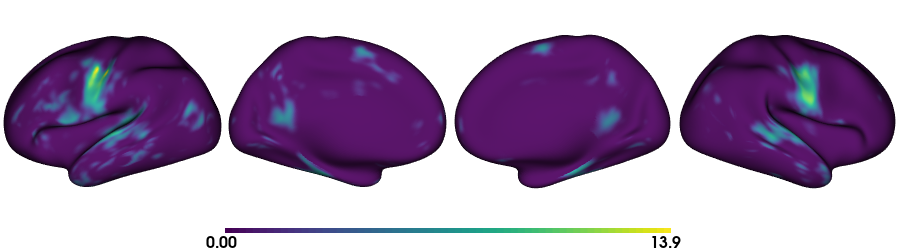

In [7]:
# Construire les chemins des fichiers en utilisant os.path.join
lh_file = os.path.join(STUDY_PATH,'masks','output','mni.L.smooth_5.32k.shape.gii')
rh_file = os.path.join(STUDY_PATH,'masks','output','mni.R.smooth_5.32k.shape.gii')
# Charger les volumes
lh_volume = [x.data for x in nib.load(lh_file).darrays]
rh_volume = [x.data for x in nib.load(rh_file).darrays]

volume_mask_weighted = np.concatenate([lh_volume[0],rh_volume[0]], axis=0)
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k, array_name=volume_mask_weighted.T, size=(900, 250), zoom=1.25,color_bar='bottom',share='both', embed_nb=True, interactive=True,nan_color=(0, 0, 0, 1), transparent_bg=False)

## Chargement des atlas glasser et extension_hcp

In [8]:
file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/HCP-MMP1_UniqueRegionList.csv'
df_exthcp = pd.read_csv(file_path)
#print(df_exthcp.head())  # Affiche les premières lignes du DataFrame

file_path = '/NAS/tupac/romain/MNI_Glasser_extHCP_etc/Glasser_2016_Table-1.xlsx'
df_gla = pd.read_excel(file_path)

#attention entre el numero de regionID et le numero dans numpy ndarray il y aun decalge de 20 l'un recommence à 181 l'autre à 200
#mapping_dict = dict(zip(df_exthcp['regionID'], df_exthcp['Cortex_ID']))
mapping_dict = dict(zip(df_exthcp.index.values+1, df_exthcp['Cortex_ID']))

mapping_dict[0] = 0
def map_values(value):
    return mapping_dict.get(value, 400)  # Remplacer 0 par une autre valeur par défaut si nécessaire

for key in mapping_dict.keys():
    # Vérifier si la clé est supérieure à 180
    if key > 180:
        # Ajouter 22 à la valeur correspondante
        mapping_dict[key] += 22

# Utiliser np.vectorize pour appliquer la fonction de correspondance
vectorized_map = np.vectorize(map_values)
glasser_fslr32k_exthcp = vectorized_map(glasser_fslr32k)

hcpext_dict = df_exthcp.set_index('Cortex_ID')['cortex'].to_dict()
glasser_dict = df_exthcp.set_index('regionID')['regionLongName'].to_dict()

#verif 
#set(mapping_dict.values())

In [9]:
clinical_data = pd.read_excel(os.path.join(STUDY_PATH,"ETUDES_24092024.xlsx"))#1082024.xlsx"))
print(f"patients : {len(clinical_data)}")

etude1=clinical_data[clinical_data['ETUDE1_IRM']=='oui']
print(f"pts in the study 1 {len(etude1)}")

# Supprimer les lignes où la colonne 'GROUPE' est égale à 'Control'
df_filtered = etude1[etude1['GROUPE'] != 'Control']
print(f"nb pts witout controls : {len(df_filtered)}")

patients : 104
pts in the study 1 83
nb pts witout controls : 83


In [10]:
scanner_data = pd.read_excel(os.path.join(STUDY_PATH,'BDD_Imagerie_Etude_Neuropsy_ProfileJD.xlsx'))
# Effectuer la jointure sur la colonne 'Nom'
merged_data = df_filtered.merge(scanner_data[['Nom', 'MagneticFieldStrength']], on='Nom', how='left')
merged_data.set_index("ID_IRM", inplace=True)
# Afficher le DataFrame résultant avec la colonne 'MagneticFieldStrength'
print(merged_data[['Nom', 'MagneticFieldStrength']])

               Nom  MagneticFieldStrength
ID_IRM                                   
PSY006   BLANCHARD                    1.5
PSY001  BAILLOEUIL                    3.0
PSY011     BUISINE                    NaN
PSY005      BILLON                    3.0
PSY113      BOULET                    1.5
...            ...                    ...
PSY109     ROSTANE                    NaN
PSY087       READY                    NaN
PSY110  SAINT OMER                    NaN
PSY088   SOUILLART                    1.5
PSY089       TOREL                    3.0

[83 rows x 2 columns]


# Chargement des données d'épaisseur corticale pour la cohorte

In [101]:
#valCT = []
subj2drop=[]
valCT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in [0]}
for smoothing_fwhm in [0]:
    print(f"Smoothing FWHM: {smoothing_fwhm} mm")
    for elt in merged_data.index:
        sub = f"sub-{str(elt)}"
        if elt.startswith("PSY"):
            path_file_lh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-L_surf-fsLR-32k_label-thickness.func.gii")
            path_file_rh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-R_surf-fsLR-32k_label-thickness.func.gii")
 
        if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
            #date_bnp = merged_data.loc[elt, 'Date_IRM_Proche_BNP']
            #date_gremots = merged_data.loc[elt, 'Date_IRM_Proche_GREMOTS']
            #if pd.notna(date_bnp) and pd.notna(date_gremots) and date_bnp != date_gremots:
            #    print(f"Index: {elt}")
            #    print(f"Date_IRM_Proche_BNP: {date_bnp}")
            #    print(f"Date_IRM_Proche_GREMOTS: {date_gremots}")
            
            # Uncomment the following lines if you need to load and process the files
            tmp_rh = nib.load(path_file_rh) 
            tmp_lh = nib.load(path_file_lh)
            volumeG1 = np.concatenate([tmp_lh.darrays[0].data, tmp_rh.darrays[0].data], axis=0)
            valCT[f"sm_{smoothing_fwhm}"].append(volumeG1)
        else:
            subj2drop.append(elt)
            print(sub)

merged_data.drop(subj2drop, inplace=True)
print(f"Number of subjects: {len(merged_data)}")
print(f"Number of subjects dropped: {len(subj2drop)}")

df_etude1_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=merged_data.index)
#RV_CHOICE je z-score dès le déaprt les épaisseur corticale ?
#df_etude1_CT = pd.DataFrame(zscore(np.array(valCT[f"sm_{smoothing_fwhm}"]), axis=1), index=merged_data.index)


Smoothing FWHM: 0 mm
sub-PSY113
sub-PSY007
sub-PSY116
sub-PSY016
sub-PSY019
sub-PSY017
sub-PSY022
sub-PSY026
sub-PSY031
sub-PSY051
sub-PSY069
sub-PSY064
sub-PSY070
sub-PSY102
sub-PSY119
sub-PSY120
sub-PSY106
sub-PSY087
Number of subjects: 65
Number of subjects dropped: 18


In [102]:
#reggression des covariables quantitative
#RV_CHOICE Z-scorer sur le genre

In [103]:
val_CT_ROI = pd.DataFrame(np.mean(np.array(valCT[f"sm_{smoothing_fwhm}"]),axis=1).astype(np.float32), columns=["val_CT_ROI"],index=merged_data.index)
df_tmp=val_CT_ROI.join(merged_data[covarQuant+covarQual+['GROUPE','SOUS_GROUPE']])
group_stats = df_tmp.groupby(['GROUPE','SOUS_GROUPE'])['val_CT_ROI'].agg(['mean', 'std','count'])
group_stats

mean       std  count
GROUPE SOUS_GROUPE                           
PPD    ADS          2.050945  0.144516     14
       BPD          1.958538  0.216871     10
bvFTD  bvFTD        1.924006  0.182582     36

* Test de Student sur l'épaisseur corticale moyenne entre les patients souffrant d'un DFT comportementale et les patients avec des troubles psychiatrique atypique

In [82]:
df_tmp = lbr.remove_outliers_bygroup(df_tmp, 'val_CT_ROI', 'GROUPE')
lbr.regress_covar_func(['val_CT_ROI'],covarQuant,df_tmp,df_tmp,display=False)
pg.ttest(df_tmp[df_tmp['GROUPE']=='bvFTD']['val_CT_ROI'],df_tmp[df_tmp['GROUPE']=='PPD']['val_CT_ROI'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.991479,61.897235,two-sided,0.003982,"[-0.2, -0.04]",0.726679,9.808,0.810305


* Test de Mann-Withney entre bipolaires et anxieux-dépressif

In [83]:
val_CT_ROI = pd.DataFrame(np.mean(np.array(valCT[f"sm_{smoothing_fwhm}"]),axis=1).astype(np.float32), columns=["val_CT_ROI"],index=merged_data.index)
df_tmp=val_CT_ROI.join(merged_data[covarQuant+covarQual+['GROUPE','SOUS_GROUPE']])

df_tmp = lbr.remove_outliers_bygroup(df_tmp, 'val_CT_ROI', 'SOUS_GROUPE')
lbr.regress_covar_func(['val_CT_ROI'],covarQuant,df_tmp,df_tmp,display=False)

pg.mwu(df_tmp[df_tmp['SOUS_GROUPE']=='ADS']['val_CT_ROI'],df_tmp[df_tmp['SOUS_GROUPE']=='BPD']['val_CT_ROI'])

,U-val,alternative,p-val,RBC,CLES
MWU,85.0,two-sided,0.395863,0.214286,0.607143


# Etude1 : 

 ## Comparaison de l'épaisseur corticale entre les groupes

### Le masque projeté à différents seuillage

Rq : Ce que l'on avait déjà montré lors des précédentes analyses (avec en plus les cartes d'atteintes cortciales)

******************************
GROUPE
*****************************
pair : ('bvFTD', 'PPD')
thresholding 0, p_value = 0.0237
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPDth0.png


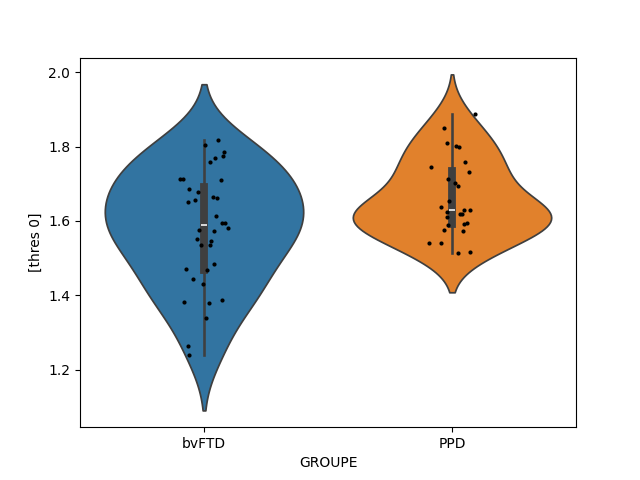

thresholding 3, p_value = 0.0286
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPDth3.png


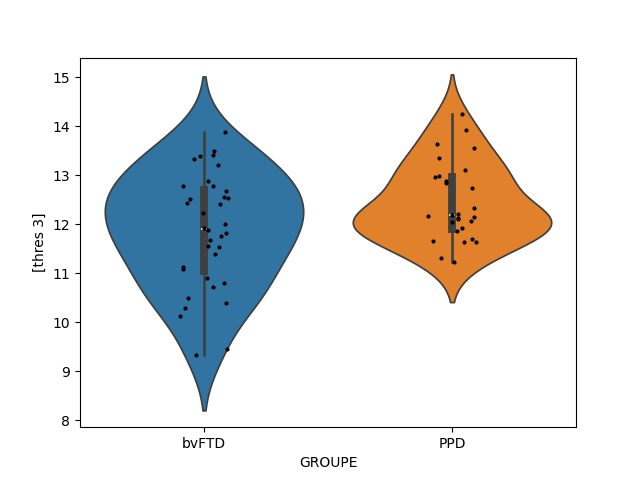

******************************
SOUS_GROUPE
*****************************
pair : ('bvFTD', 'BPD')
pair : ('bvFTD', 'ADS')
pair : ('BPD', 'ADS')


In [84]:

for groupUsed in ['GROUPE','SOUS_GROUPE'] :
    print(f"******************************\n{groupUsed}\n*****************************")  
    # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
    pairs = list(combinations(merged_data[groupUsed].dropna().unique(), 2))
    for pair in pairs: # Itérez sur tous les couples
        ssdf_CT = df_etude1_CT.loc[merged_data[groupUsed].isin([pair[0],pair[1]])]
        ssdf_covar = merged_data.loc[ssdf_CT.index] 
        print(f"pair : {pair}")
        for thres_prob in range(0,np.max(volume_mask_weighted).astype(int)+1,3):            
            ind=np.where(volume_mask_weighted>thres_prob)[0]
            #CTvalinThres_mask=np.mean(ssdf_CT[np.where(volume_mask_weighted>thres_prob)[0]],axis=1).astype(np.float32)
            CTvalinThres_mask=np.mean(ssdf_CT[ind]*volume_mask_weighted[ind],axis=1).astype(np.float32)
            val_CT_ROI = pd.DataFrame(CTvalinThres_mask, columns=["val_CT_ROI"])
            df_tmp=val_CT_ROI.join(ssdf_covar[covarQuant+covarQual+[groupUsed]])
            #supprimer les outliers
            df_tmp = lbr.remove_outliers_bygroup(df_tmp, 'val_CT_ROI', groupUsed)
            #reggression des covariables quantitative
            lbr.regress_covar_func(['val_CT_ROI'],covarQuant,df_tmp,df_tmp,display=False)
            #RV_CHOICE Z-scorer sur le genre
            #Z-score par groupe pour les covariables qualitative
            #df_tmp['val_CT_ROI'] = df_tmp.groupby(covarQual+[groupUsed])['val_CT_ROI'].transform(lambda x: (x - x.mean()) / x.std())

            gp1=df_tmp[df_tmp[groupUsed].isin([pair[0]])]['val_CT_ROI'].astype(np.float32)
            gp2=df_tmp[df_tmp[groupUsed].isin([pair[1]])]['val_CT_ROI'].astype(np.float32)
            if (len(gp1)>30) and (len(gp2)>30):
                ret=pg.ttest(gp1,gp2,paired=False,alternative='less',confidence=0.95)
            else :
                ret=pg.mwu(gp1,gp2,alternative='less')
            if(ret['p-val'].iloc[0]<0.05):
                print(f"thresholding {thres_prob}, p_value = {np.round(ret['p-val'].iloc[0],4)}")
                # Supprimer les groupes non présents dans df_copy de la copie du dictionnaire palette
                palette_copy = {group: color for group, color in palette.items() if group in pair}
                sns.stripplot(df_tmp,y='val_CT_ROI',x=groupUsed,size=3,color="black", order=palette_copy.keys())
                sns.violinplot(df_tmp,y='val_CT_ROI',x=groupUsed,hue=groupUsed,palette=palette_copy,order=palette_copy.keys())
                #sns.stripplot(df_tmp,y='val_CT_ROI',x=groupUsed,size=3,hue='GENDER')
                #sns.violinplot(df_tmp,y='val_CT_ROI',x=groupUsed,hue='GENDER',split='GENDER')
                figure_title=os.path.join(STUDY_PATH,f"groups_compare_{pair[0]}_{pair[1]}th{thres_prob}.png")
                plt.ylabel(f'[thres {thres_prob}]')
                print(figure_title)
                plt.savefig(figure_title)
                plt.close()
                display(Image(filename=figure_title))


### Selection des regions dans Glasser

Selected regions :
	Frontal_Eye_Fields_L (  1 9 ) 
	PeriSylvian_Language_Area_L (  2 24 ) 
	Area_dorsal_23_a+b_L (  3 33 ) 
	Dorsal_area_6_L (  4 53 ) 
	Area_IFJa_L (  5 78 ) 
	Area_OP1-SII_L (  6 100 ) 
	Auditory_5_Complex_L (  7 124 ) 
	ParaHippocampal_Area_1_L (  8 125 ) 
	ParaHippocampal_Area_3_L (  9 126 ) 
	Dorsal_Transitional_Visual_Area_L (  10 141 ) 
	Auditory_4_Complex_L (  11 174 ) 
	Area_STSv_anterior_L (  12 175 ) 
	Dorsal_area_6_R (  13 233 ) 
	Auditory_5_Complex_R (  14 304 ) 
	ParaHippocampal_Area_1_R (  15 305 ) 
	ParaHippocampal_Area_3_R (  16 306 ) 
	Area_STSv_posterior_R (  17 309 ) 
	Auditory_4_Complex_R (  18 354 ) 
	Area_STSv_anterior_R (  19 355 ) 


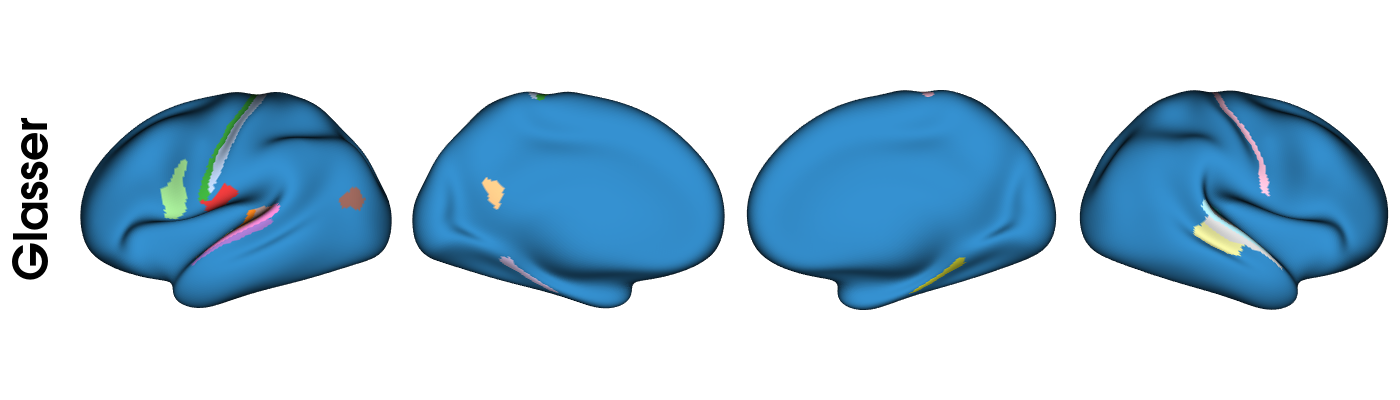

In [103]:
unique_values = np.unique(glasser_fslr32k)
roi_list_glasser = []
print(f"Selected regions :")
for value in unique_values:
    # Obtenir les indices où glasser_fslr32k est égal à la valeur courante
    indices = np.where(glasser_fslr32k == value)
    sum_mask = np.sum(volume_mask_weighted[indices])
    if  sum_mask/len(indices[0]) >2.5:
        roi_list_glasser.append(value)
        print(f"\t{df_exthcp.iloc[value].regionLongName} ({lbr.ansi_colors20[len(roi_list_glasser)]} {lbr.BOLD} {len(roi_list_glasser)} {value} {lbr.RESET}) ")# : {len(indices[0])},{np.round(sum_mask,0)}, {sum_mask/len(indices[0])}")

##mask = np.isin(glasser_fslr32k, roi_list_glasser)
##mask=np.where(np.isin(glasser_fslr32k, roi_list_glasser),glasser_fslr32k, 0)

# Create a new array with the same shape as glasser_fslr32k
new_glasser_fslr32k = np.zeros_like(glasser_fslr32k)

for cpt in range(1,20):
    new_glasser_fslr32k[31186+cpt]=cpt
    
# Replace values in glasser_fslr32k with their indices in roi_list_glasser
for idx, roi in enumerate(roi_list_glasser):
    #print(idx+1, roi)
    new_glasser_fslr32k[glasser_fslr32k == roi] = idx + 1  # Indices start from 1

plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,new_glasser_fslr32k,
        label_text=["Glasser"], cmap='tab20', 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

******************************
GROUPE
***************************** 
pair : ('bvFTD', 'PPD')


Area_OP1-SII_L, p_value = 0.0489
        mean   std  count
GROUPE                   
PPD     2.45  0.20     28
bvFTD   2.32  0.23     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPD_onglasser.png


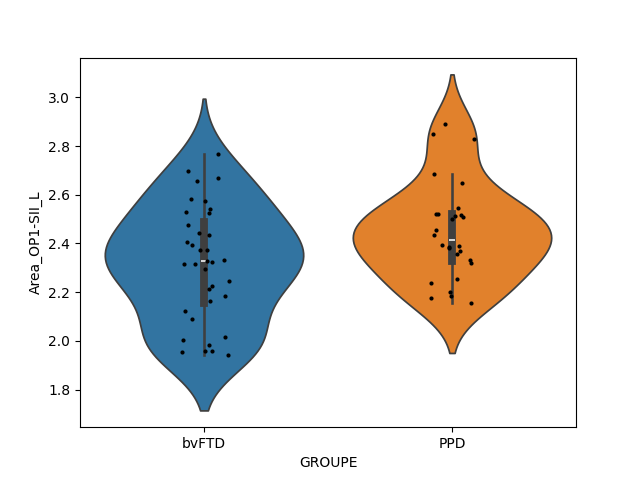

ParaHippocampal_Area_1_L, p_value = 0.0146
        mean   std  count
GROUPE                   
PPD     2.43  0.24     28
bvFTD   2.25  0.28     35
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPD_onglasser.png


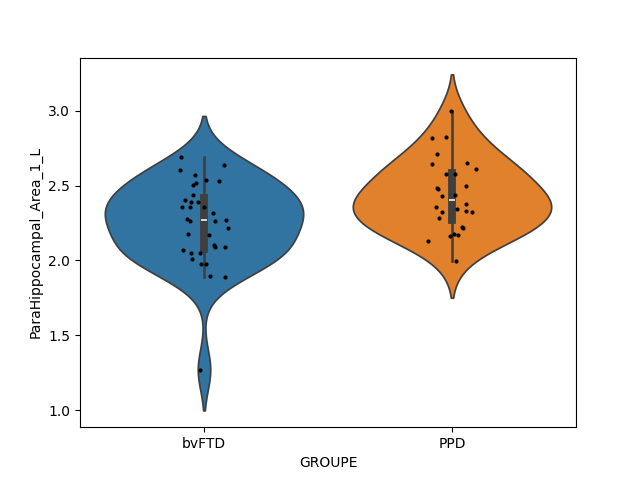

ParaHippocampal_Area_1_R, p_value = 0.0023
        mean   std  count
GROUPE                   
PPD     2.71  0.21     28
bvFTD   2.50  0.32     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPD_onglasser.png


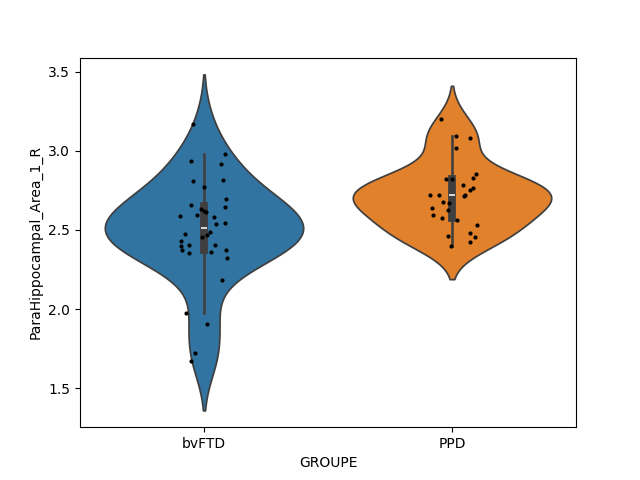

Area_STSv_posterior_R, p_value = 0.0279
        mean   std  count
GROUPE                   
PPD     2.24  0.16     28
bvFTD   2.13  0.27     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPD_onglasser.png


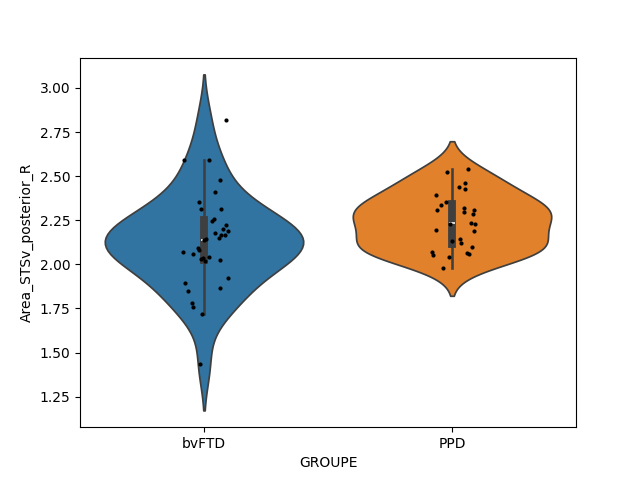

*** Area_STSv_anterior_R, p_fdr = 0.0432 ***
******************************
SOUS_GROUPE
***************************** 
pair : ('bvFTD', 'BPD')
pair : ('bvFTD', 'ADS')
ParaHippocampal_Area_1_L, p_value = 0.0385
             mean   std  count
SOUS_GROUPE                   
ADS          2.30  0.22     14
bvFTD        2.11  0.27     35
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_ADS_onglasser.png


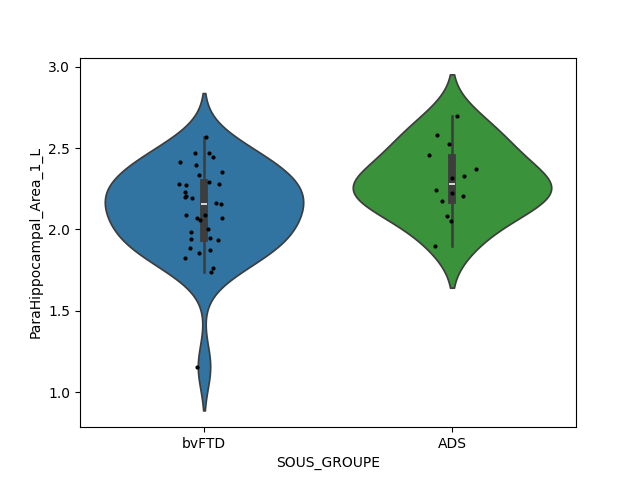

ParaHippocampal_Area_1_R, p_value = 0.0059
             mean   std  count
SOUS_GROUPE                   
ADS          2.63  0.22     14
bvFTD        2.37  0.32     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_ADS_onglasser.png


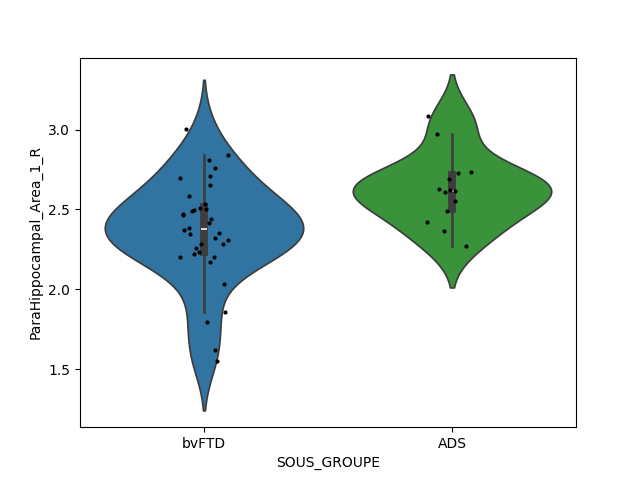

Area_STSv_posterior_R, p_value = 0.0351
             mean   std  count
SOUS_GROUPE                   
ADS          2.15  0.14     14
bvFTD        2.01  0.26     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_ADS_onglasser.png


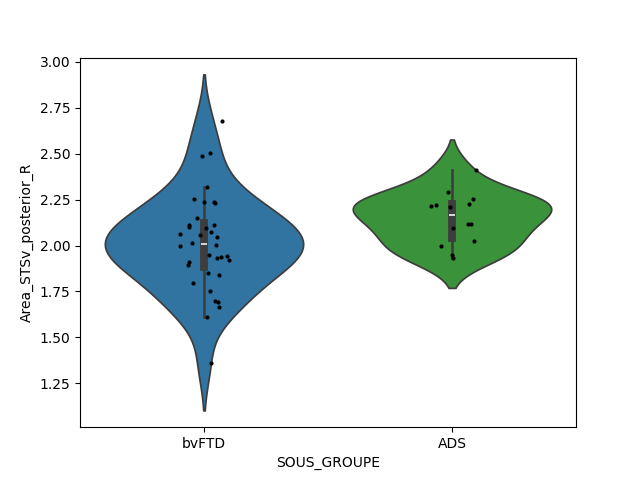

Area_STSv_anterior_R, p_value = 0.018
             mean   std  count
SOUS_GROUPE                   
ADS          2.33  0.23     14
bvFTD        2.10  0.31     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_ADS_onglasser.png


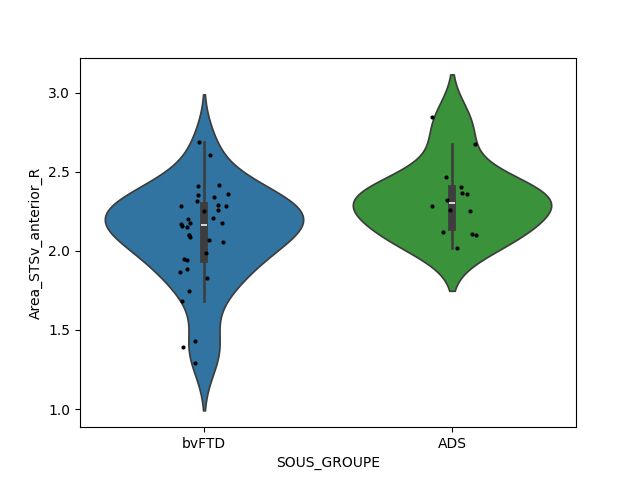

pair : ('BPD', 'ADS')


In [86]:
p_values=[]
for groupUsed in ['GROUPE','SOUS_GROUPE'] :
    print(f"******************************\n{groupUsed}\n***************************** ")  
    # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
    pairs = list(combinations(merged_data[groupUsed].dropna().unique(), 2))
    for pair in pairs: # Itérez sur tous les couples
        ssdf_CT = df_etude1_CT.loc[merged_data[groupUsed].isin([pair[0],pair[1]])]
        ssdf_covar = merged_data.loc[ssdf_CT.index] 
        print(f"pair : {pair}")
        for roi_number in roi_list_glasser:            
            ind=np.where(glasser_fslr32k==roi_number)[0]
            #CTvalinThres_mask=np.mean(ssdf_CT[np.where(volume_mask_weighted>thres_prob)[0]],axis=1).astype(np.float32)
            CTvalinThres_mask=np.mean(ssdf_CT[ind],axis=1).astype(np.float32)
            val_CT_ROI = pd.DataFrame(CTvalinThres_mask, columns=["val_CT_ROI"])
            df_tmp=val_CT_ROI.join(ssdf_covar[covarQuant+covarQual+[groupUsed]])
            #supprimer les outliers
            df_tmp = lbr.remove_outliers_bygroup(df_tmp, 'val_CT_ROI', groupUsed,3)
            #reggression des covariables quantitative
            lbr.regress_covar_func(['val_CT_ROI'],covarQuant,df_tmp,df_tmp,display=False)
            #RV_CHOICE Z-scorer sur le genre
            #Z-score par groupe pour les covariables qualitative
            #df_tmp['val_CT_ROI'] = df_tmp.groupby(covarQual+[groupUsed])['val_CT_ROI'].transform(lambda x: (x - x.mean()) / x.std())

            gp1=df_tmp[df_tmp[groupUsed].isin([pair[0]])]['val_CT_ROI'].astype(np.float32)
            gp2=df_tmp[df_tmp[groupUsed].isin([pair[1]])]['val_CT_ROI'].astype(np.float32)
            if (len(gp1)>30) and (len(gp2)>30):
                ret=pg.ttest(gp1,gp2,paired=False,alternative='two-sided',confidence=0.95)
            else :
                ret=pg.mwu(gp1,gp2,alternative='two-sided')
            p_values.append(ret['p-val'].iloc[0])
            if(ret['p-val'].iloc[0]<0.05):
                print(f"{df_exthcp.iloc[roi_number].regionLongName}, p_value = {np.round(ret['p-val'].iloc[0],4)}")
                group_stats = df_tmp.groupby(groupUsed)['val_CT_ROI'].agg(['mean', 'std','count'])
                print(np.round(group_stats,2))
                # Supprimer les groupes non présents dans df_copy de la copie du dictionnaire palette
                palette_copy = {group: color for group, color in palette.items() if group in pair}

                sns.stripplot(df_tmp,y='val_CT_ROI',x=groupUsed,size=3,color="black",order=palette_copy.keys())
                sns.violinplot(df_tmp,y='val_CT_ROI',x=groupUsed,hue=groupUsed,palette=palette_copy,order=palette_copy.keys())
                #sns.stripplot(df_tmp,y='val_CT_ROI',x=groupUsed,size=3,hue='GENDER')
                #sns.violinplot(df_tmp,y='val_CT_ROI',x=groupUsed,hue='GENDER',split='GENDER')
                figure_title=os.path.join(STUDY_PATH,f"groups_compare_{pair[0]}_{pair[1]}_onglasser.png")
                print(figure_title)
                plt.ylabel(df_exthcp.iloc[roi_number].regionLongName)
                plt.savefig(figure_title)
                plt.close()
                display(Image(filename=figure_title))
        
        b_fdr,p_fdr=sm.stats.fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)                
        for i in range(len(roi_list_glasser)):
            if b_fdr[i]:  
                print(f"{lbr.BOLD}{lbr.RED}*** {df_exthcp.iloc[roi_number].regionLongName}, p_fdr = {np.round(p_fdr[i], 4)} ***{lbr.RESET}")          

        #for val,roi in zip(p_fdr,roi_list_hcpext):
        #    print(f'{hcpext_dict.get(roi)} p_fdr={np.round(val,4)}')


### Selection des regions dans HCP extension

Selected regions :
	Somatosensory_and_Motor_L (  1 6 )
	Posterior_Opercular_L (  2 9 )
	Early_Auditory_L (  3 10 )
	Auditory_Association_L (  4 11 )
	Medial_Temporal_L (  5 13 )
	Somatosensory_and_Motor_R (  6 28 )
	Posterior_Opercular_R (  7 31 )
	Early_Auditory_R (  8 32 )
	Auditory_Association_R (  9 33 )


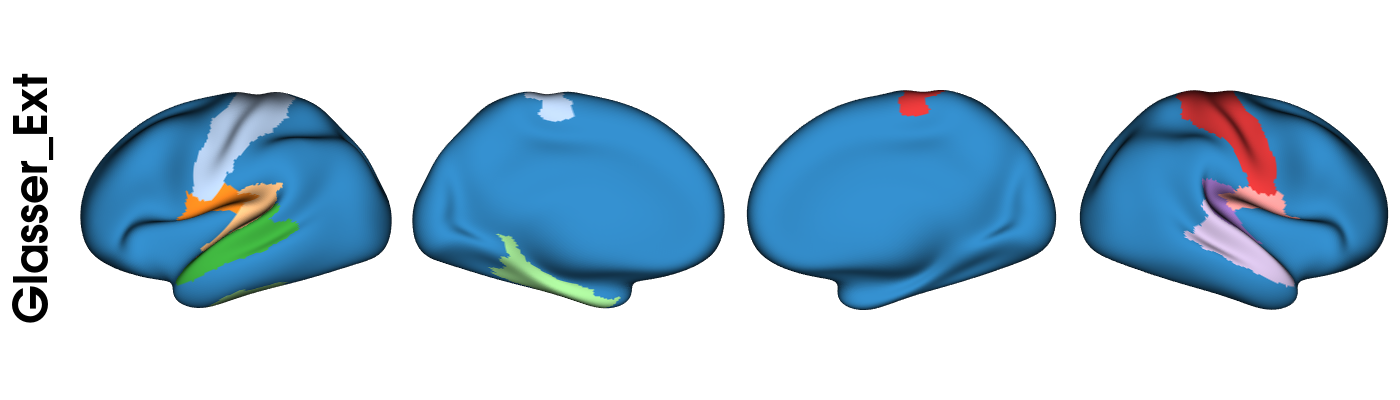

In [130]:
unique_values = np.unique(glasser_fslr32k_exthcp)
roi_list_hcpext = []
print(f"Selected regions :")
for value in unique_values:
    # Obtenir les indices où glasser_fslr32k est égal à la valeur courante
    indices = np.where(glasser_fslr32k_exthcp == value)
    sum_mask = np.sum(volume_mask_weighted[indices])
    if  sum_mask/len(indices[0]) >1:
        roi_list_hcpext.append(value)
        if value < 23:
            print(f"\t{hcpext_dict.get(value)}_L ({lbr.ansi_colors20[len(roi_list_hcpext)]} {lbr.BOLD} {len(roi_list_hcpext)} {value} {lbr.RESET})")#  : {len(indices[0])},{np.round(sum_mask,0)}, {sum_mask/len(indices[0])}")
        else:
            print(f"\t{hcpext_dict.get(value-22)}_R ({lbr.ansi_colors20[len(roi_list_hcpext)]} {lbr.BOLD} {len(roi_list_hcpext)} {value} {lbr.RESET})")#  : {len(indices[0])},{np.round(sum_mask,0)}, {sum_mask/len(indices[0])}")

#mask = np.isin(glasser_fslr32k_exthcp, roi_list_hcpext)
#mask=np.where(np.isin(glasser_fslr32k_exthcp, roi_list_hcpext),glasser_fslr32k_exthcp, 0)

# Create a new array with the same shape as glasser_fslr32k
new_exthcp_fslr32k = np.zeros_like(glasser_fslr32k_exthcp)

# Replace values in glasser_fslr32k with their indices in roi_list_hcpext
for idx, roi in enumerate(roi_list_hcpext):
    #print(idx+1, roi)
    new_exthcp_fslr32k[glasser_fslr32k_exthcp == roi] = idx + 1  # Indices start from 1

for cpt in range(1,20):
    new_exthcp_fslr32k[31186+cpt]=cpt
    
plot_hemispheres(vinflated_left_fslr32k,vinflated_right_fslr32k,new_exthcp_fslr32k,
        label_text=["Glasser_Ext"], cmap='tab20', 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)

******************************
GROUPE
*****************************
pair : ('bvFTD', 'PPD')
Posterior_Opercular_L, p_value = 0.0489
        mean   std  count
GROUPE                   
PPD     2.46  0.17     28
bvFTD   2.35  0.21     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPD_onhcpext.png


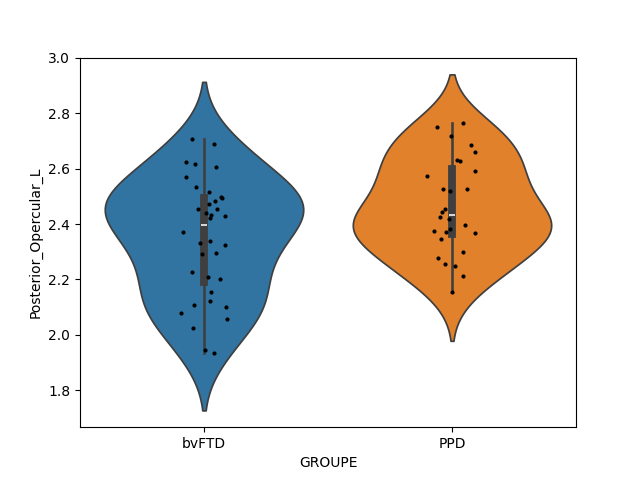

Auditory_Association_L, p_value = 0.0342
        mean   std  count
GROUPE                   
PPD     2.44  0.17     28
bvFTD   2.29  0.27     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPD_onhcpext.png


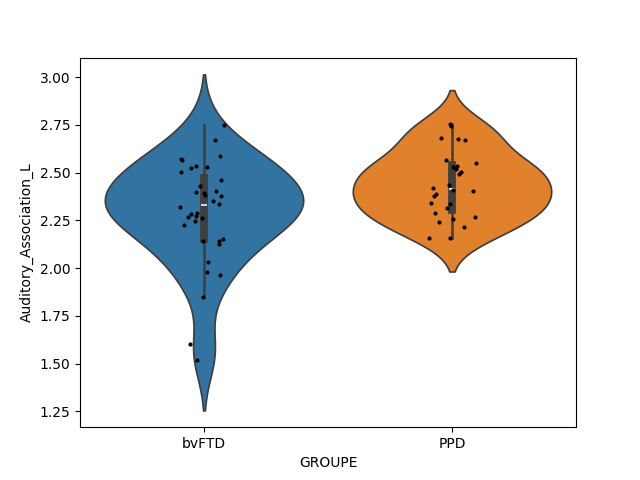

Posterior_Opercular_R, p_value = 0.0064
        mean   std  count
GROUPE                   
PPD     2.46  0.18     28
bvFTD   2.31  0.21     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPD_onhcpext.png


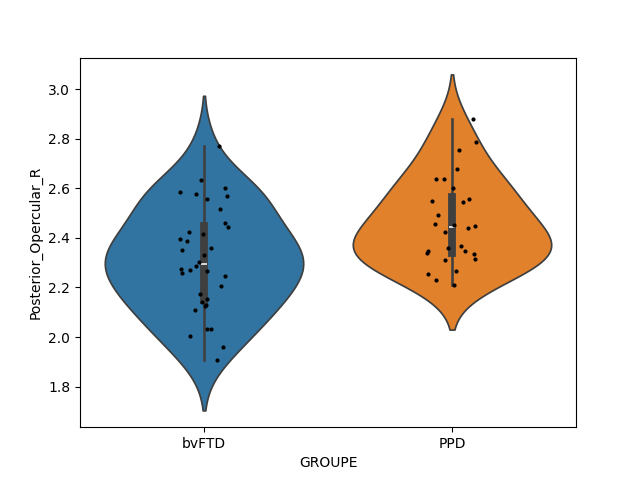

Auditory_Association_R, p_value = 0.0069
        mean   std  count
GROUPE                   
PPD     2.58  0.16     28
bvFTD   2.40  0.28     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_PPD_onhcpext.png


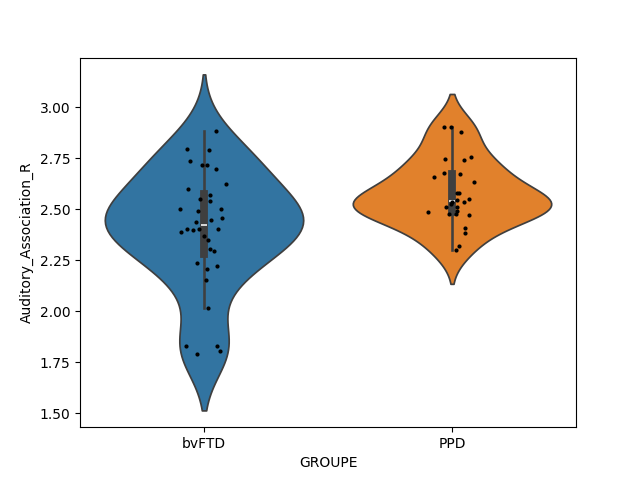

*** Posterior_Opercular_R, p_fdr = 0.0312 ***
*** Auditory_Association_R, p_fdr = 0.0312 ***
******************************
SOUS_GROUPE
*****************************
pair : ('bvFTD', 'BPD')
pair : ('bvFTD', 'ADS')
Posterior_Opercular_R, p_value = 0.0067
             mean   std  count
SOUS_GROUPE                   
ADS          2.35  0.18     14
bvFTD        2.16  0.20     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_ADS_onhcpext.png


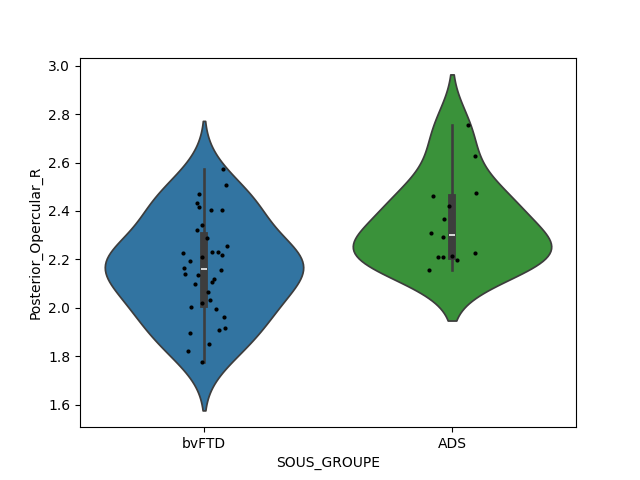

Early_Auditory_R, p_value = 0.0333
             mean   std  count
SOUS_GROUPE                   
ADS          2.26  0.16     14
bvFTD        2.10  0.23     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_ADS_onhcpext.png


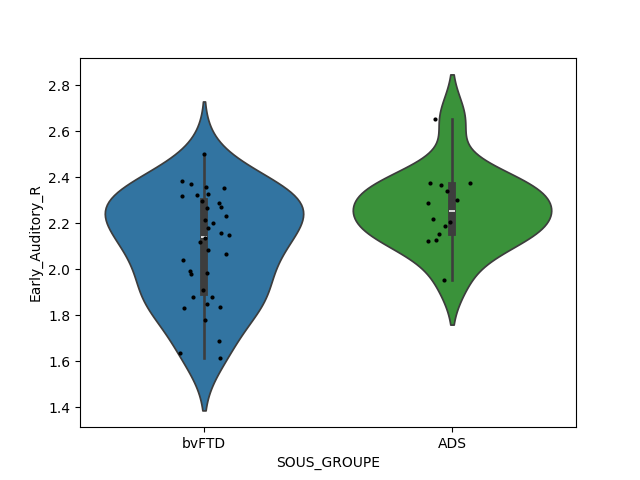

Auditory_Association_R, p_value = 0.018
             mean   std  count
SOUS_GROUPE                   
ADS          2.45  0.17     14
bvFTD        2.25  0.28     36
/NAS/dumbo/protocoles/PSY_bvFTD/groups_compare_bvFTD_ADS_onhcpext.png


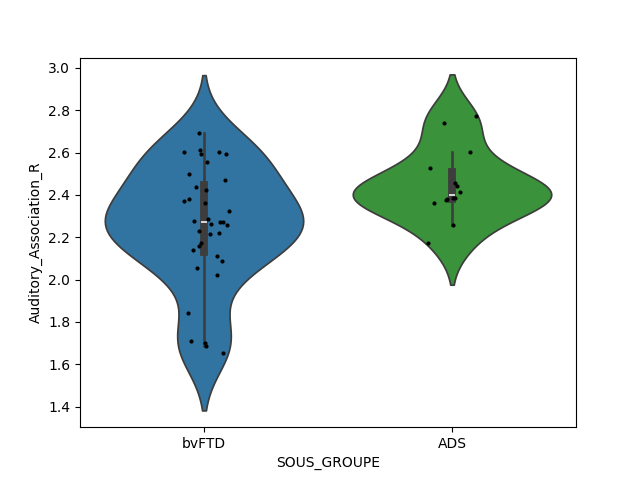

pair : ('BPD', 'ADS')


In [88]:
for groupUsed in ['GROUPE','SOUS_GROUPE'] :
    print(f"******************************\n{groupUsed}\n*****************************")  
    # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
    pairs = list(combinations(merged_data[groupUsed].dropna().unique(), 2))
    for pair in pairs: # Itérez sur tous les couples
        ssdf_CT = df_etude1_CT.loc[merged_data[groupUsed].isin([pair[0],pair[1]])]
        ssdf_covar = merged_data.loc[ssdf_CT.index] 
        print(f"pair : {pair}")
        p_values=[]
        for roi_number in roi_list_hcpext:
            ind=np.where(glasser_fslr32k_exthcp==roi_number)[0]
            #CTvalinThres_mask=np.mean(ssdf_CT[np.where(volume_mask_weighted>thres_prob)[0]],axis=1).astype(np.float32)
            CTvalinThres_mask=np.mean(ssdf_CT[ind],axis=1).astype(np.float32)
            val_CT_ROI = pd.DataFrame(CTvalinThres_mask, columns=["val_CT_ROI"])
            df_tmp=val_CT_ROI.join(ssdf_covar[covarQuant+covarQual+[groupUsed]])
            #supprimer les outliers
            df_tmp = lbr.remove_outliers_bygroup(df_tmp, 'val_CT_ROI', groupUsed)
            #reggression des covariables quantitative
            lbr.regress_covar_func(['val_CT_ROI'],covarQuant,df_tmp,df_tmp,display=False)
            #RV_CHOICE Z-scorer sur le genre
            #Z-score par groupe pour les covariables qualitative
            #df_tmp['val_CT_ROI'] = df_tmp.groupby(covarQual+[groupUsed])['val_CT_ROI'].transform(lambda x: (x - x.mean()) / x.std())

            gp1=df_tmp[df_tmp[groupUsed].isin([pair[0]])]['val_CT_ROI'].astype(np.float32)
            gp2=df_tmp[df_tmp[groupUsed].isin([pair[1]])]['val_CT_ROI'].astype(np.float32)
            if (len(gp1)>29) and (len(gp2)>29):
                ret=pg.ttest(gp1,gp2,paired=False,alternative='two-sided',confidence=0.95)
            else :
                ret=pg.mwu(gp1,gp2,alternative='two-sided')
            p_values.append(ret['p-val'].iloc[0])
            if(ret['p-val'].iloc[0]<0.05):
                if roi_number < 23:
                    roi_name=hcpext_dict.get(roi_number)+'_L'
                else:
                    roi_name=hcpext_dict.get(roi_number-22)+'_R'              
                print(f"{roi_name}, p_value = {np.round(ret['p-val'].iloc[0],4)}")
                group_stats = df_tmp.groupby(groupUsed)['val_CT_ROI'].agg(['mean', 'std','count'])
                print(np.round(group_stats,2))
                # Supprimer les groupes non présents dans df_copy de la copie du dictionnaire palette
                palette_copy = {group: color for group, color in palette.items() if group in pair}

                sns.stripplot(df_tmp,y='val_CT_ROI',x=groupUsed,size=3,color="black", order=palette_copy.keys())
                sns.violinplot(df_tmp,y='val_CT_ROI',x=groupUsed,hue=groupUsed,palette=palette_copy,order=palette_copy.keys())
                figure_title=os.path.join(STUDY_PATH,f"groups_compare_{pair[0]}_{pair[1]}_onhcpext.png")
                print(figure_title)
                plt.ylabel(roi_name)
                plt.savefig(figure_title)
                plt.close()
                display(Image(filename=figure_title))
            
        b_fdr,p_fdr=sm.stats.fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)
        for i in range(len(roi_list_hcpext)):
            if b_fdr[i]:
                if roi_list_hcpext[i] < 23:
                    roi_name=hcpext_dict.get(roi_list_hcpext[i])+'_L'
                else:
                    roi_name=hcpext_dict.get(roi_list_hcpext[i]-22)+'_R'    
                print(f"{lbr.BOLD}{lbr.RED}*** {roi_name}, p_fdr = {np.round(p_fdr[i], 4)} ***{lbr.RESET}")          

        #for val,roi in zip(p_fdr,roi_list_hcpext):
        #    print(f'{hcpext_dict.get(roi)} p_fdr={np.round(val,4)}')

## Corrélation des variables à l'épaisseur corticale

### Variables corrélées pour l'étude 1

In [89]:
var4CorrEtude1=clinical_data.columns[23:42]
var4CorrEtude1

Index(['FER', 'mFP', 'mFP_SocialContext', 'mFP_Mentalizing', 'mFP_Controls',
       'Praxies', 'VOSP', 'TMT_B_A', 'Stroop_3-1', 'Empan_endroit',
       'Empan_envers', 'CODE_WAIS', 'Denomination', 'DTLA', 'FCSRT_RL',
       'FCSRT_RT', 'TOP10', 'FER_EVC', 'FER_EVN'],
      dtype='object')

### Le masque à différents seuillages

Nombre de sujets : 3
Series([], dtype: float64)


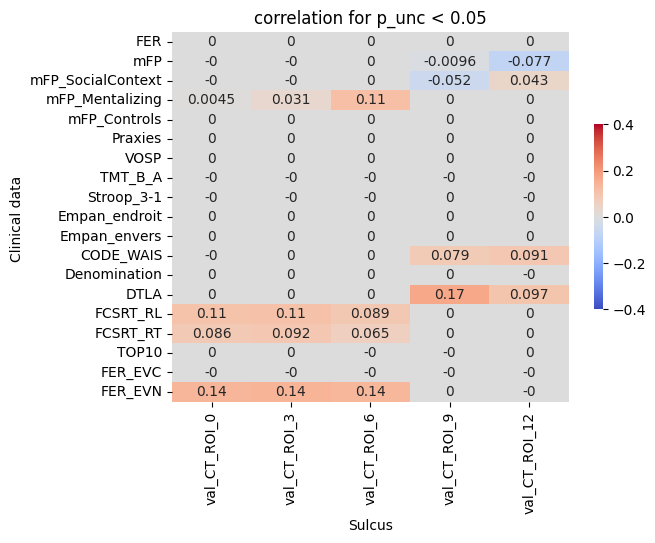

<Figure size 640x480 with 0 Axes>

In [90]:
df_tmp = pd.DataFrame(index=df_etude1_CT.index)
for thres_prob in range(0,np.max(volume_mask_weighted).astype(int)+1,3):            
    ind=np.where(volume_mask_weighted>thres_prob)[0]
    CTvalinThres_mask=np.mean(df_etude1_CT[ind]*volume_mask_weighted[ind],axis=1).astype(np.float32)
    df_tmp[f'val_CT_ROI_{thres_prob}'] = CTvalinThres_mask

lbr.filter_group(df_tmp,f'val_CT_ROI_{thres_prob}',nb_std=3)
lbr.regress_covar_func(df_tmp.columns,covarQuant,df_tmp,merged_data,display=False)
lbr.corr_sillons_var_func(df_tmp.columns,var4CorrEtude1,df_tmp,merged_data,thres_sign=0.05,corr_thres=0.3)

### Pour l'atlas de glasser

La bibil à RORO loaded
Nombre de sujets : 3
Imaging data  Clinical data  
DTLA          Dorsal_area_6_R    0.328239
dtype: float64


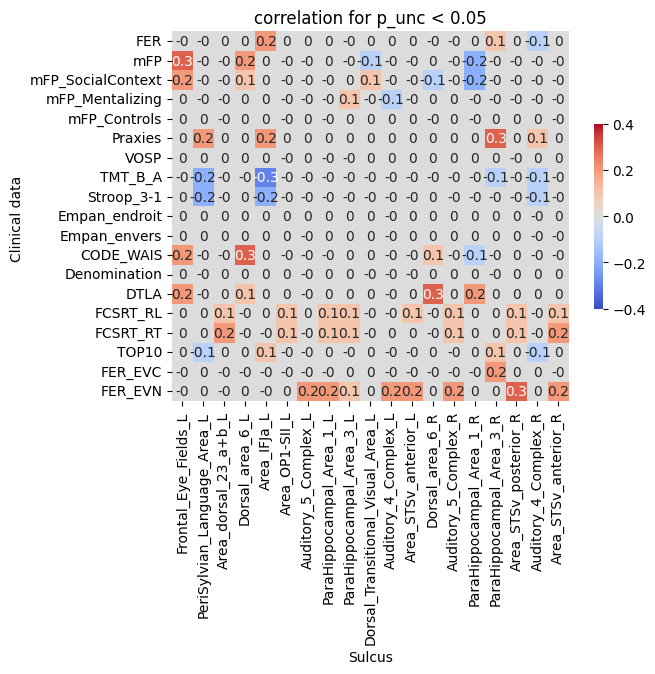

<Figure size 640x480 with 0 Axes>

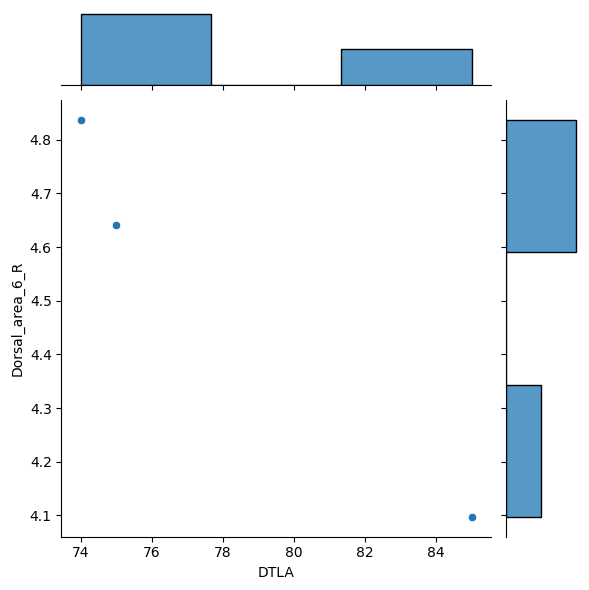

<Figure size 640x480 with 0 Axes>

In [123]:
reload(lbr)
df_tmp = pd.DataFrame(index=df_etude1_CT.index)
for roi_number in roi_list_glasser:
    ind=np.where(glasser_fslr32k==roi_number)[0]
    CTvalinThres_mask=np.mean(df_etude1_CT[ind]*volume_mask_weighted[ind],axis=1).astype(np.float32)
    roi_name=df_exthcp.iloc[roi_number].regionLongName
    df_tmp[f'{roi_name}'] = CTvalinThres_mask

lbr.filter_group(df_tmp,roi_name,nb_std=3)
lbr.regress_covar_func(df_tmp.columns,covarQuant,df_tmp,merged_data,display=False)
lbr.corr_sillons_var_func(df_tmp.columns,var4CorrEtude1,df_tmp,merged_data,thres_sign=0.05,corr_thres=0.3)

### Pour l'atlas HCP étendue

Nombre de sujets : 3
Series([], dtype: float64)


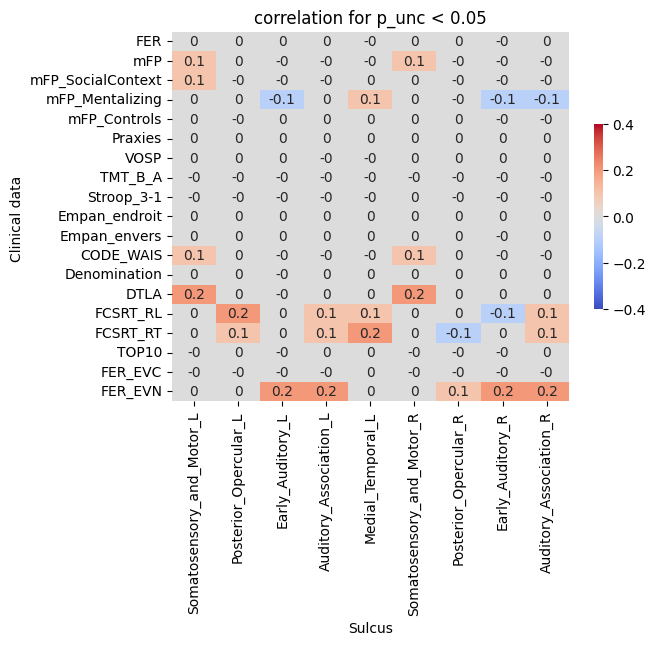

<Figure size 640x480 with 0 Axes>

In [124]:
df_tmp = pd.DataFrame(index=df_etude1_CT.index)

for roi_number in roi_list_hcpext:            
    ind=np.where(glasser_fslr32k_exthcp==roi_number)[0]
    CTvalinThres_mask=np.mean(df_etude1_CT[ind]*volume_mask_weighted[ind],axis=1).astype(np.float32)
    if roi_number < 23:
        roi_name=hcpext_dict.get(roi_number)+'_L'
    else:
        roi_name=hcpext_dict.get(roi_number-22)+'_R'
    df_tmp[f'{roi_name}'] = CTvalinThres_mask

lbr.filter_group(df_tmp,roi_name,nb_std=3)
lbr.regress_covar_func(df_tmp.columns,covarQuant,df_tmp,merged_data,display=False)
lbr.corr_sillons_var_func(df_tmp.columns,var4CorrEtude1,df_tmp,merged_data,thres_sign=0.05,corr_thres=0.3)

# Etude 2 : 

## Corrélation de l'épaisseur corticale dans le masque fourni par rapport aux différents scores 


In [91]:
df_etude2_scoreAndCov_index=clinical_data.where(clinical_data['ETUDE2_IRM']=='oui')['ETUDE2_IRM'].dropna().index.dropna()
df_etude2_scoreAndCov=clinical_data.loc[df_etude2_scoreAndCov_index]

In [ ]:
scanner_data = pd.read_excel(os.path.join(STUDY_PATH,'BDD_Imagerie_Etude_Neuropsy_ProfileJD.xlsx'))
# Effectuer la jointure sur la colonne 'Nom'
merged_data = df_etude2_scoreAndCov.merge(scanner_data[['Nom', 'MagneticFieldStrength']], on='Nom', how='left')
merged_data.set_index("ID_IRM", inplace=True)
# Afficher le DataFrame résultant avec la colonne 'MagneticFieldStrength'
print(merged_data[['Nom', 'MagneticFieldStrength']])

In [ ]:
#valCT = []
subj2drop=[]
valCT = {f"sm_{smoothing_fwhm}": [] for smoothing_fwhm in [0]}
for smoothing_fwhm in [0]:
    print(f"Smoothing FWHM: {smoothing_fwhm} mm")
    for elt in merged_data.index:
        sub = f"sub-{str(elt)}"
        if elt.startswith("PSY"):
            path_file_lh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-L_surf-fsLR-32k_label-thickness.func.gii")
            path_file_rh = os.path.join(DERIVATIVE_DIR1, "micapipe_v0.2.0", sub, "ses-1", "maps", sub + f"_ses-1_hemi-R_surf-fsLR-32k_label-thickness.func.gii")
 
        if os.path.exists(path_file_lh) and os.path.exists(path_file_rh):
            #date_bnp = merged_data.loc[elt, 'Date_IRM_Proche_BNP']
            #date_gremots = merged_data.loc[elt, 'Date_IRM_Proche_GREMOTS']
            #if pd.notna(date_bnp) and pd.notna(date_gremots) and date_bnp != date_gremots:
            #    print(f"Index: {elt}")
            #    print(f"Date_IRM_Proche_BNP: {date_bnp}")
            #    print(f"Date_IRM_Proche_GREMOTS: {date_gremots}")
            
            # Uncomment the following lines if you need to load and process the files
            tmp_rh = nib.load(path_file_rh) 
            tmp_lh = nib.load(path_file_lh)
            volumeG1 = np.concatenate([tmp_lh.darrays[0].data, tmp_rh.darrays[0].data], axis=0)
            valCT[f"sm_{smoothing_fwhm}"].append(volumeG1)
        else:
            subj2drop.append(elt)
            print(sub)

merged_data.drop(subj2drop, inplace=True)
print(f"Number of subjects: {len(merged_data)}")
print(f"Number of subjects dropped: {len(subj2drop)}")

df_etude2_CT = pd.DataFrame(np.array(valCT[f"sm_{smoothing_fwhm}"]), index=merged_data.index)

Variables à correler pour étude 2

In [94]:
var4CorrEtude2=clinical_data.columns[58:]
var4CorrEtude2

Index(['GREMOT_LS', 'GREMOT_FluFruits', 'GREMOT_FluLettres',
       'GREMOT_DenoPersonnes', 'GREMOT_Discoursnarratif', 'GREMOT_VerifOP',
       'PROSODIE_LS_DF0', 'PROSODIE_LS_STDVF0', 'PROSODIE_DN_DF0',
       'PROSODIE_DN_STDVF0', 'CATEGORIAL_Total_Clu_Size', 'CATEGORIAL_Switch',
       'LITTERAL_Total_Clu_Size', 'LITTERAL_Switch'],
      dtype='object')

In [95]:
merged_data[var4CorrEtude2].agg(['count'])

,GREMOT_LS,GREMOT_FluFruits,GREMOT_FluLettres,GREMOT_DenoPersonnes,GREMOT_Discoursnarratif,GREMOT_VerifOP,PROSODIE_LS_DF0,PROSODIE_LS_STDVF0,PROSODIE_DN_DF0,PROSODIE_DN_STDVF0,CATEGORIAL_Total_Clu_Size,CATEGORIAL_Switch,LITTERAL_Total_Clu_Size,LITTERAL_Switch
count,30,30,30,30,30,28,26,26,26,26,27,27,28,28


## Le masque à différents seuillages

Nombre de sujets : 23
Series([], dtype: float64)


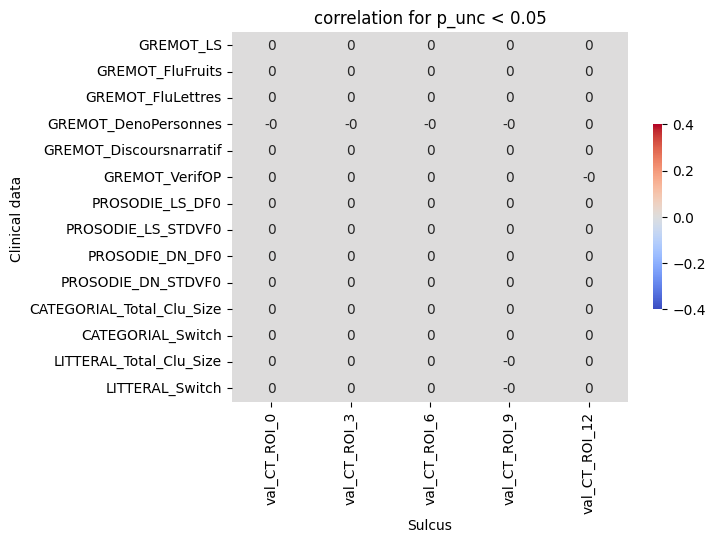

<Figure size 640x480 with 0 Axes>

In [96]:
df_tmp = pd.DataFrame(index=df_etude2_CT.index)
for thres_prob in range(0,np.max(volume_mask_weighted).astype(int)+1,3):            
    ind=np.where(volume_mask_weighted>thres_prob)[0]
    CTvalinThres_mask=np.mean(df_etude2_CT[ind]*volume_mask_weighted[ind],axis=1).astype(np.float32)
    df_tmp[f'val_CT_ROI_{thres_prob}'] = CTvalinThres_mask

lbr.filter_group(df_tmp,f'val_CT_ROI_{thres_prob}',nb_std=3)
lbr.regress_covar_func(df_tmp.columns,covarQuant,df_tmp,merged_data,display=False)
lbr.corr_sillons_var_func(df_tmp.columns,var4CorrEtude2,df_tmp,merged_data,thres_sign=0.05,corr_thres=0.3)

## Pour l'atlas de glasser

La bibil à RORO loaded
Nombre de sujets : 23
Imaging data             Clinical data                    
GREMOT_LS                PeriSylvian_Language_Area_L          0.474693
                         Dorsal_Transitional_Visual_Area_L    0.310013
                         Auditory_4_Complex_L                 0.415583
                         Auditory_5_Complex_R                 0.383512
                         Auditory_4_Complex_R                 0.409052
GREMOT_FluLettres        Area_dorsal_23_a+b_L                 0.330093
                         Area_IFJa_L                          0.474132
                         ParaHippocampal_Area_3_L             0.430698
PROSODIE_LS_DF0          Frontal_Eye_Fields_L                 0.469971
                         Dorsal_Transitional_Visual_Area_L    0.340244
PROSODIE_LS_STDVF0       PeriSylvian_Language_Area_L          0.305777
                         Dorsal_area_6_L                      0.409176
                         Area_OP1-SII_L     

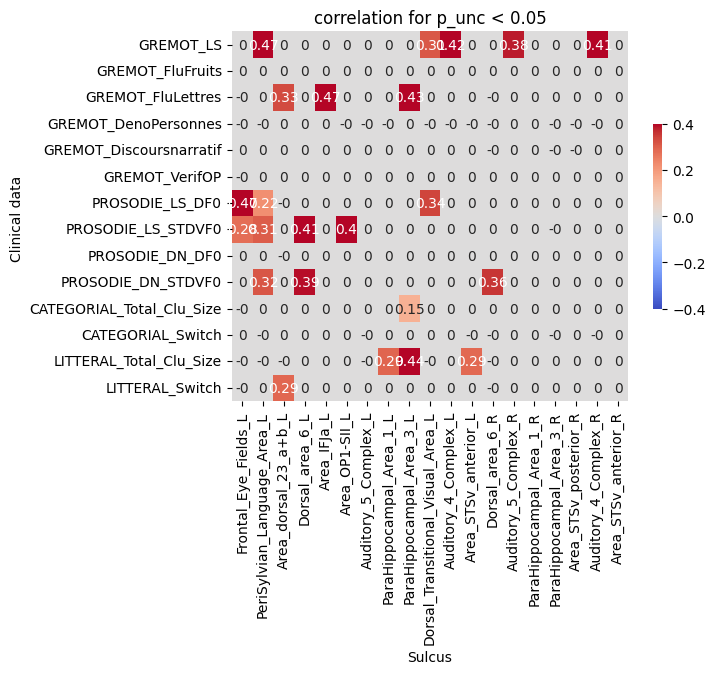

<Figure size 640x480 with 0 Axes>

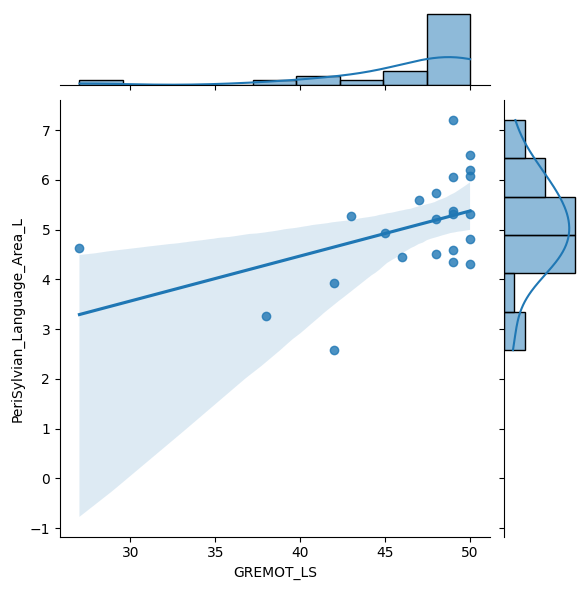

<Figure size 640x480 with 0 Axes>

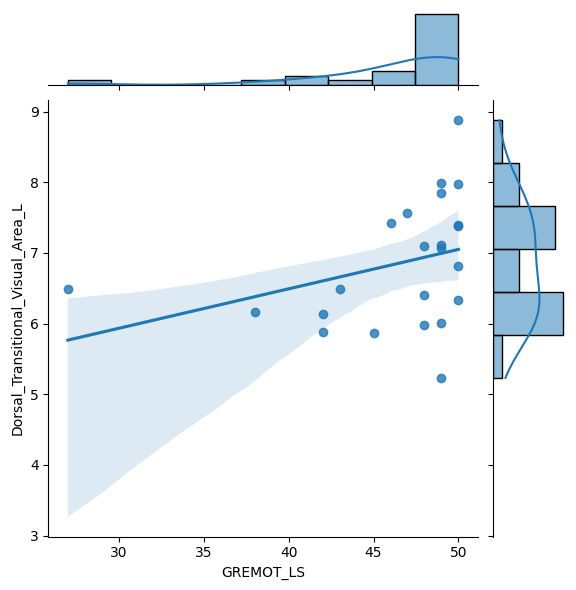

<Figure size 640x480 with 0 Axes>

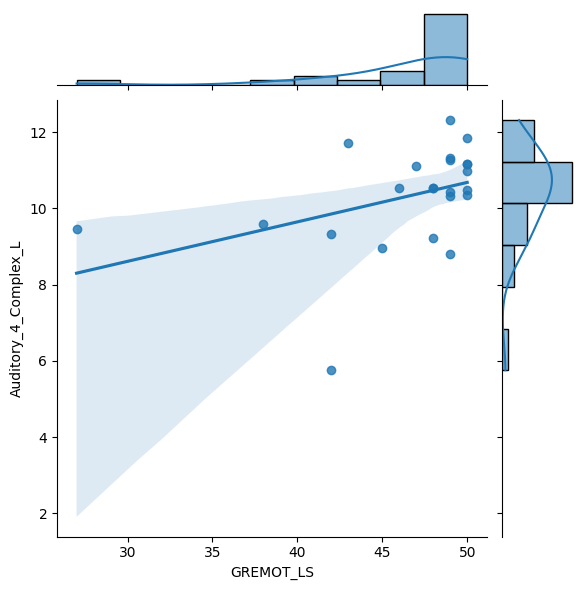

<Figure size 640x480 with 0 Axes>

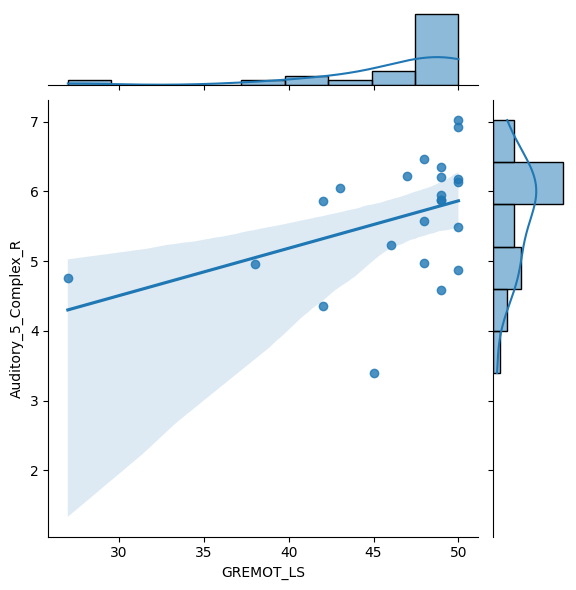

<Figure size 640x480 with 0 Axes>

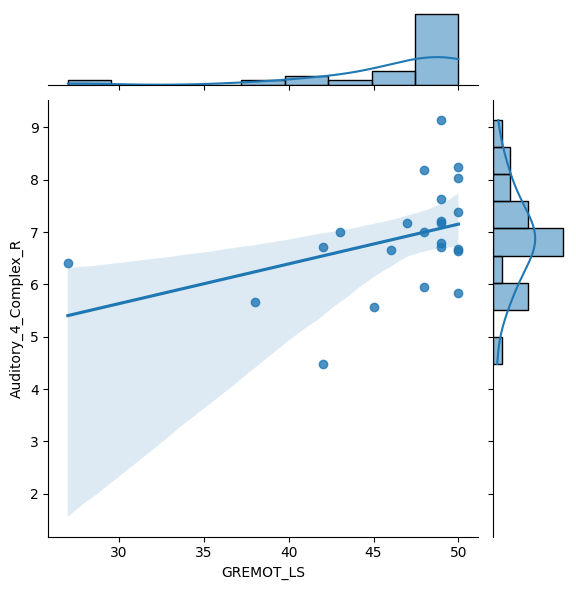

<Figure size 640x480 with 0 Axes>

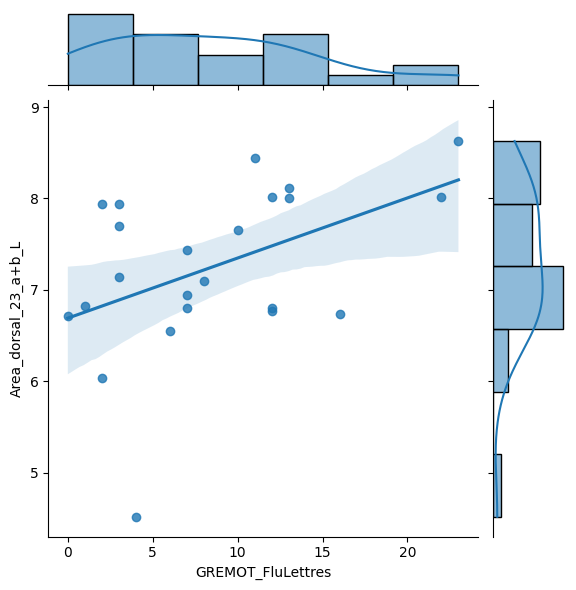

<Figure size 640x480 with 0 Axes>

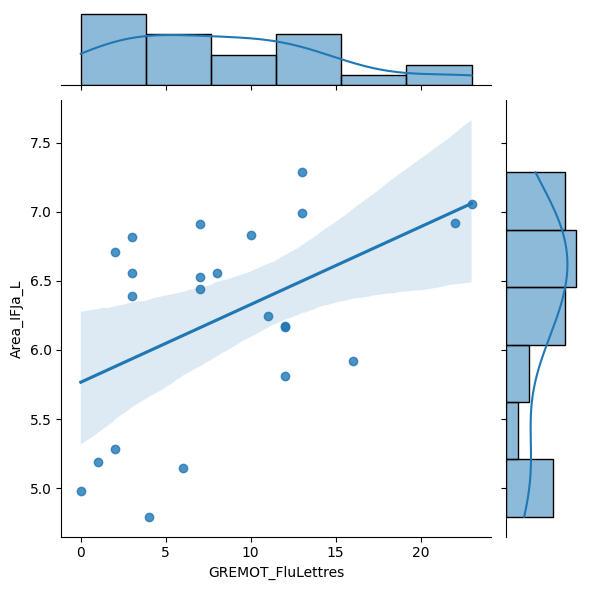

<Figure size 640x480 with 0 Axes>

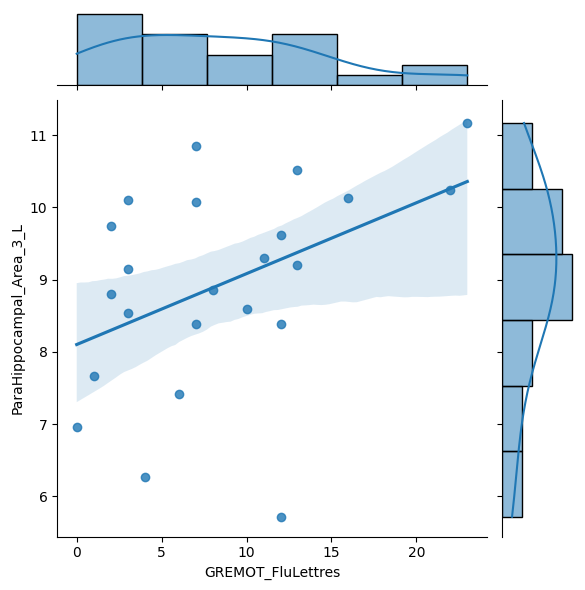

<Figure size 640x480 with 0 Axes>

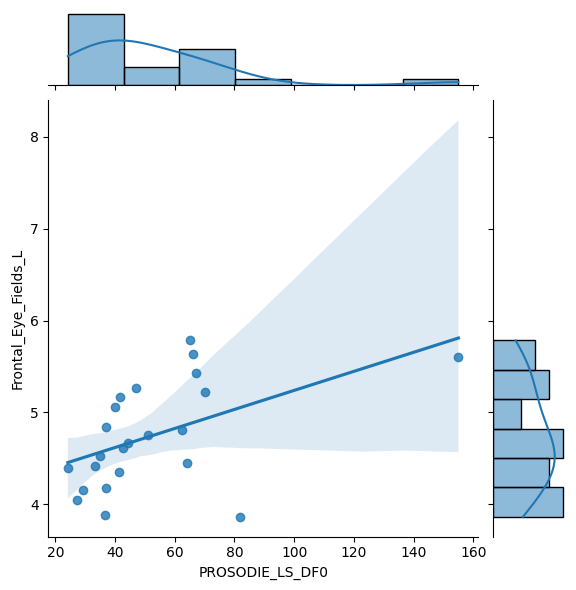

<Figure size 640x480 with 0 Axes>

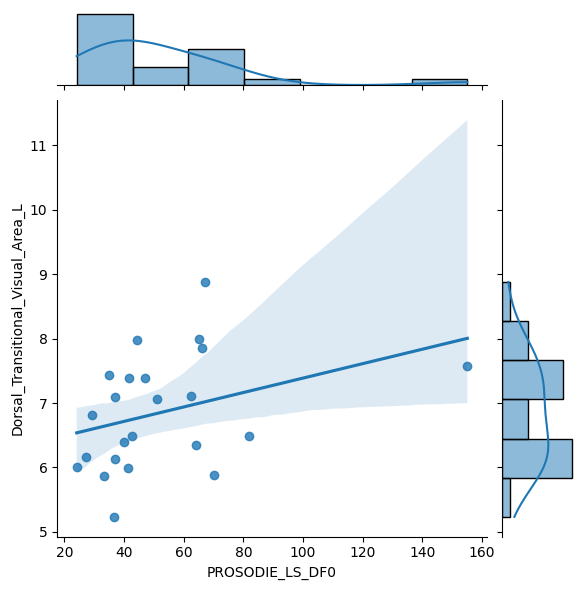

<Figure size 640x480 with 0 Axes>

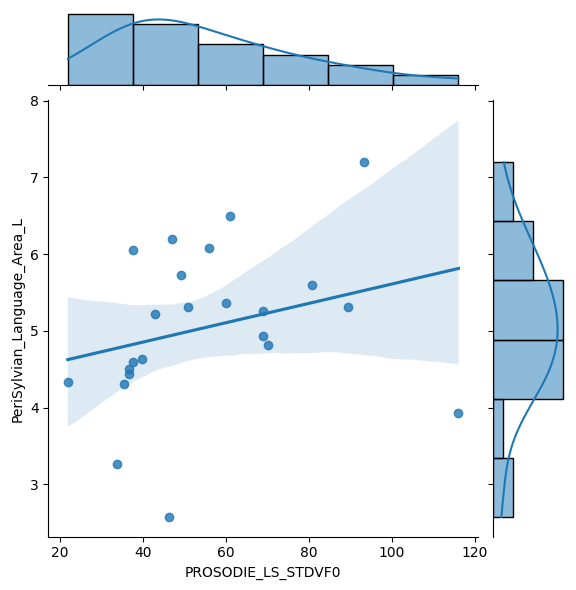

<Figure size 640x480 with 0 Axes>

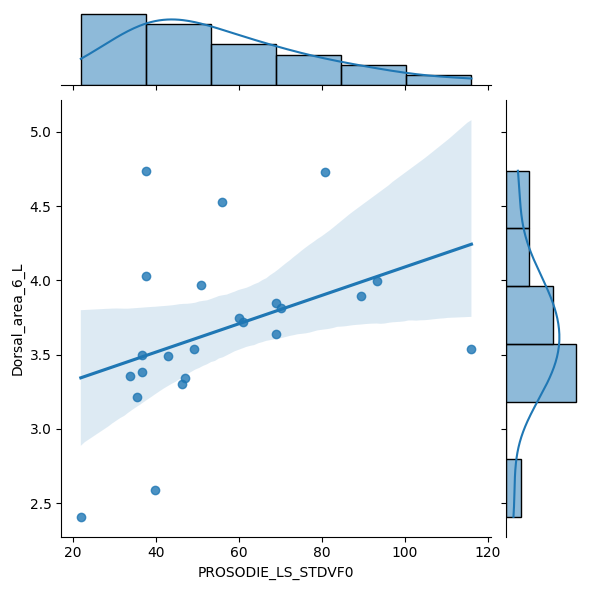

<Figure size 640x480 with 0 Axes>

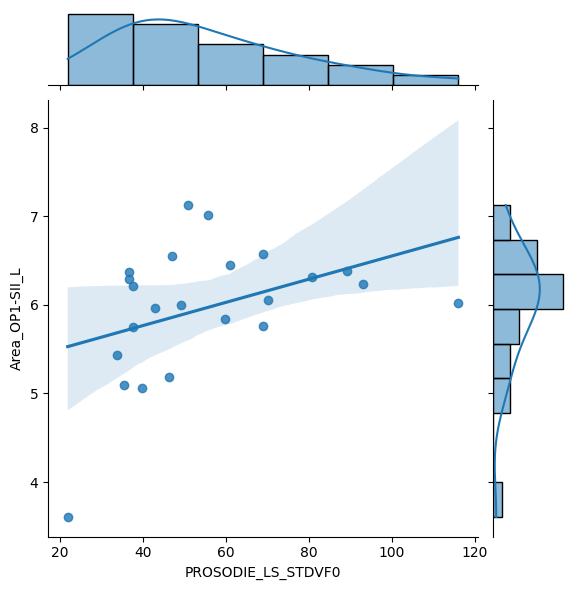

<Figure size 640x480 with 0 Axes>

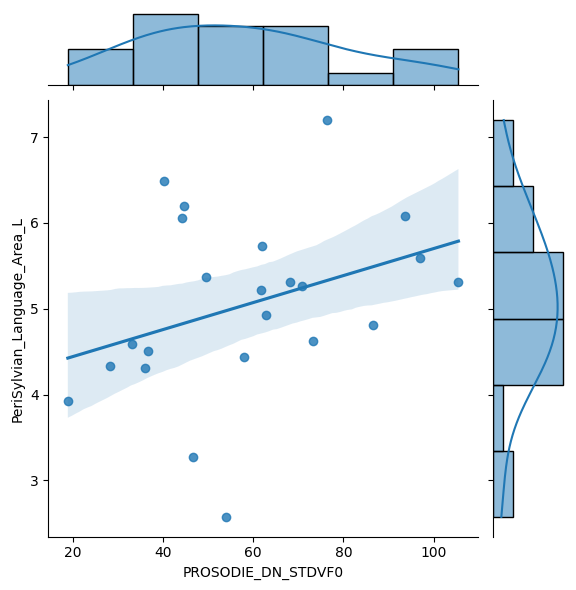

<Figure size 640x480 with 0 Axes>

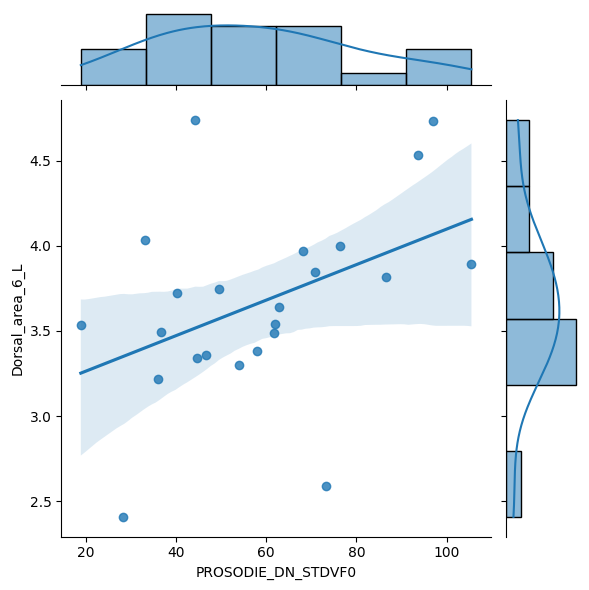

<Figure size 640x480 with 0 Axes>

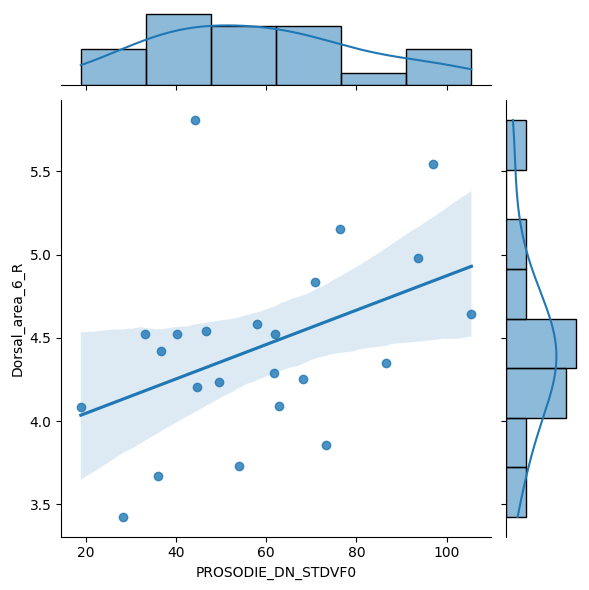

<Figure size 640x480 with 0 Axes>

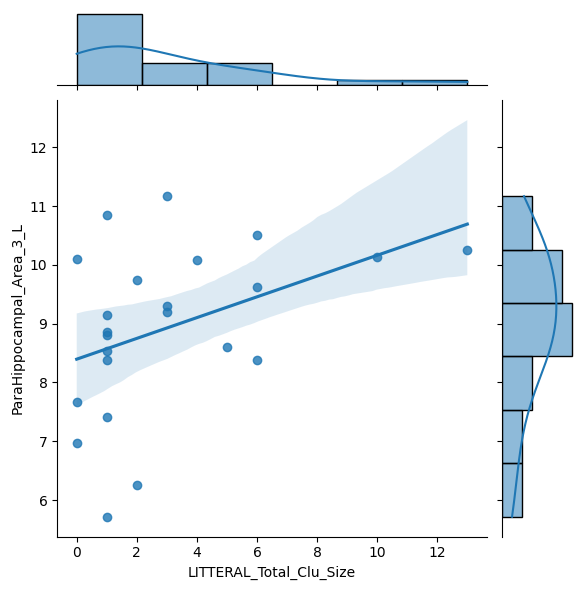

<Figure size 640x480 with 0 Axes>

In [97]:
reload(lbr)
df_tmp = pd.DataFrame(index=df_etude2_CT.index)
for roi_number in roi_list_glasser:
    ind=np.where(glasser_fslr32k==roi_number)[0]
    CTvalinThres_mask=np.mean(df_etude2_CT[ind]*volume_mask_weighted[ind],axis=1).astype(np.float32)
    roi_name=df_exthcp.iloc[roi_number].regionLongName
    df_tmp[f'{roi_name}'] = CTvalinThres_mask

lbr.filter_group(df_tmp,roi_name,nb_std=3)
lbr.regress_covar_func(df_tmp.columns,covarQuant,df_tmp,merged_data,display=False)
lbr.corr_sillons_var_func(df_tmp.columns,var4CorrEtude2,df_tmp,merged_data,thres_sign=0.05,corr_thres=0.3)

## Pour l'atlas HCP étendu

Nombre de sujets : 23
Imaging data       Clinical data            
GREMOT_LS          Posterior_Opercular_L        0.380562
                   Early_Auditory_L             0.495311
                   Early_Auditory_R             0.439928
GREMOT_FluLettres  Medial_Temporal_L            0.408827
PROSODIE_LS_DF0    Somatosensory_and_Motor_L    0.379998
dtype: float64


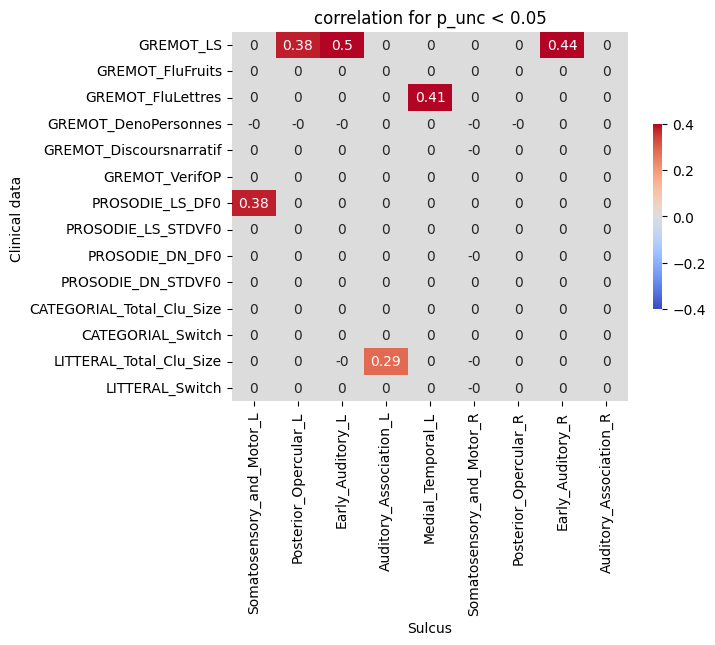

<Figure size 640x480 with 0 Axes>

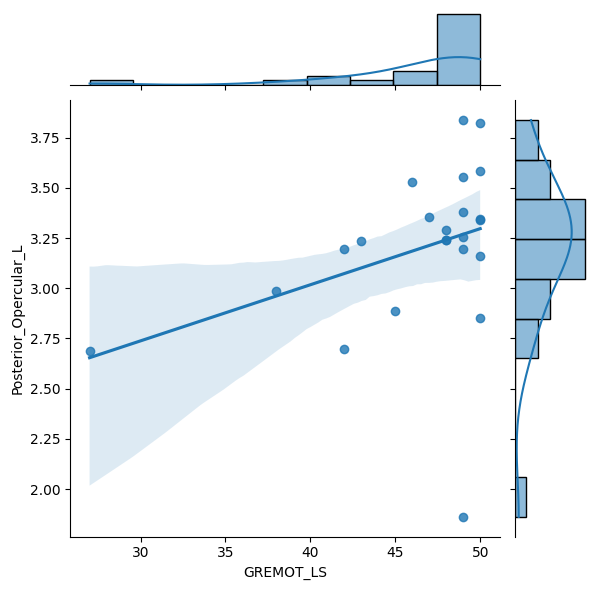

<Figure size 640x480 with 0 Axes>

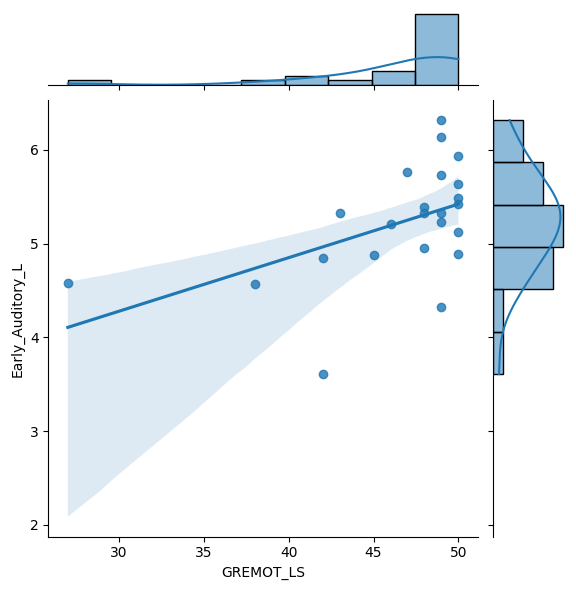

<Figure size 640x480 with 0 Axes>

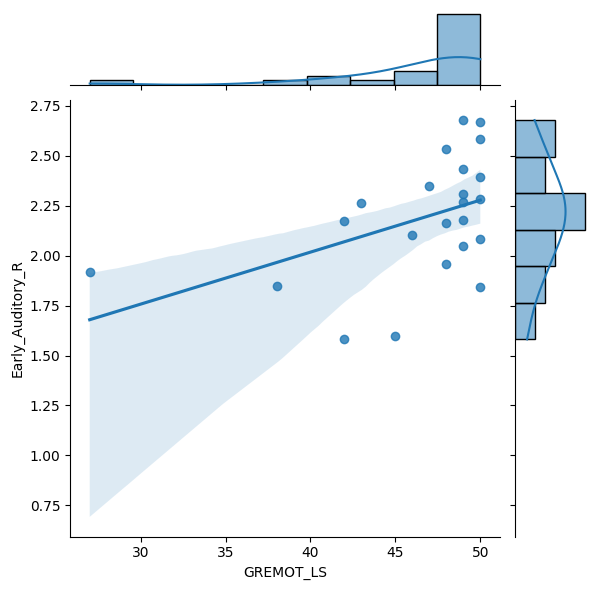

<Figure size 640x480 with 0 Axes>

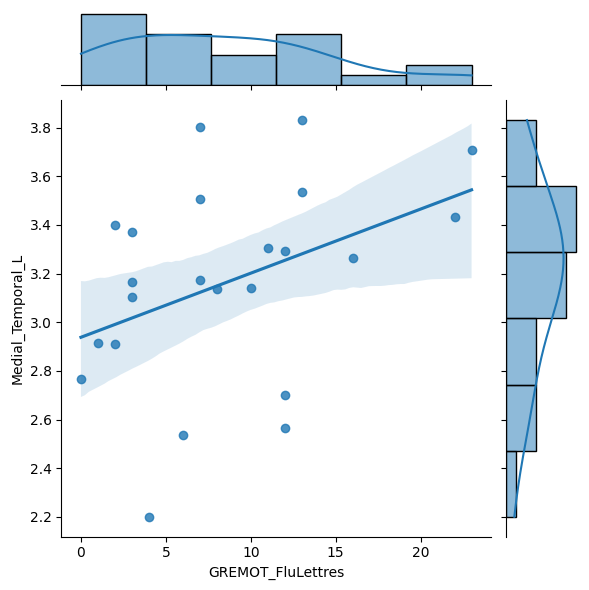

<Figure size 640x480 with 0 Axes>

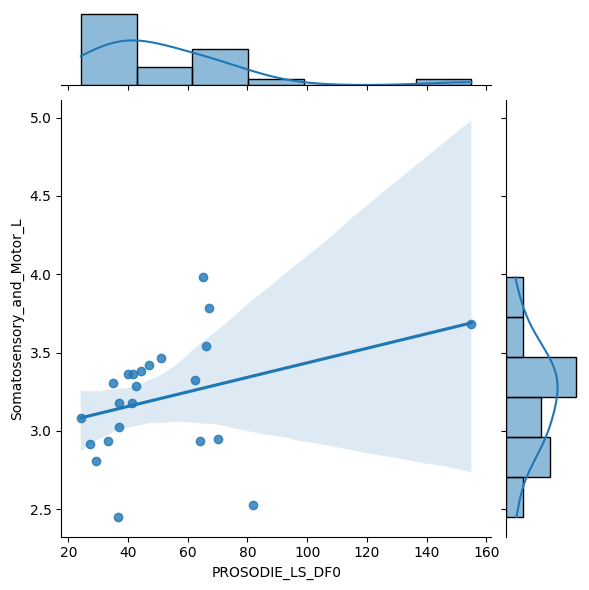

<Figure size 640x480 with 0 Axes>

In [98]:
df_tmp = pd.DataFrame(index=df_etude2_CT.index)

for roi_number in roi_list_hcpext:            
    ind=np.where(glasser_fslr32k_exthcp==roi_number)[0]
    CTvalinThres_mask=np.mean(df_etude2_CT[ind]*volume_mask_weighted[ind],axis=1).astype(np.float32)
    if roi_number < 23:
        roi_name=hcpext_dict.get(roi_number)+'_L'
    else:
        roi_name=hcpext_dict.get(roi_number-22)+'_R'
    df_tmp[f'{roi_name}'] = CTvalinThres_mask

lbr.filter_group(df_tmp,roi_name,nb_std=3)
lbr.regress_covar_func(df_tmp.columns,covarQuant,df_tmp,merged_data,display=False)
lbr.corr_sillons_var_func(df_tmp.columns,var4CorrEtude2,df_tmp,merged_data,thres_sign=0.05,corr_thres=0.3)

# Outils pour la sauvegarde en pdf

In [127]:
!jupyter nbconvert --no-input --to pdf DFTvc_MB_etude2.ipynb 

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot trust

Jupyter command `jupyter-nbconvert` not found.


In [70]:
import gudhi as gd

# Convertir le graphe en un complexe simplicial
simplex_tree = gd.SimplexTree()

# Ajouter les sommets (0-simplexes)
for i, vertex in enumerate(vertices):
    simplex_tree.insert([i], filtration=0)

In [68]:
# Ajouter les arêtes (1-simplexes)
for triangle in faces:
    for i in range(3):
        for j in range(i + 1, 3):
            simplex_tree.insert([triangle[i], triangle[j]], filtration=0)

In [57]:
# Ajouter les triangles (2-simplexes)
for triangle in faces:
    simplex_tree.insert(triangle, filtration=0)

<Axes: title={'center': 'Persistence diagram'}, xlabel='Birth', ylabel='Death'>

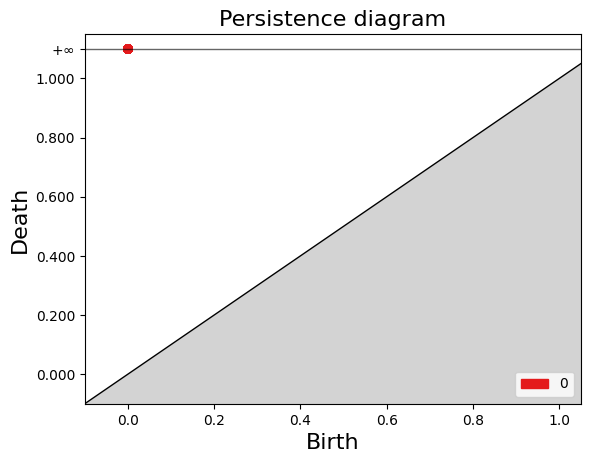

In [71]:
# Calculer les diagrammes de persistance
simplex_tree.make_filtration_non_decreasing()
diag = simplex_tree.persistence()

# Afficher les diagrammes de persistance
gd.plot_persistence_diagram(diag)

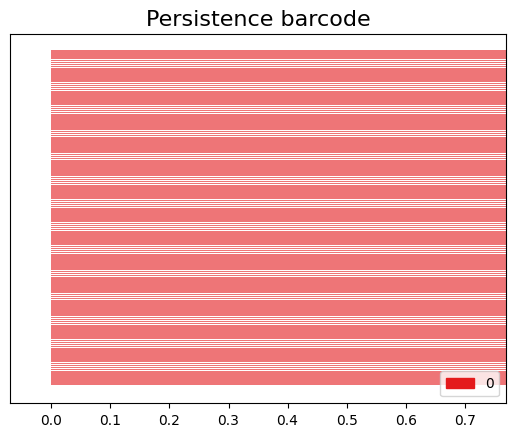

In [65]:
import matplotlib.pyplot as plt
import gudhi

point_cloud = vertices

rips_complex = gudhi.RipsComplex(points=point_cloud, max_edge_length=0.7)
simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)
diag = simplex_tree.persistence(min_persistence=0.4)

gudhi.plot_persistence_barcode(diag)
plt.show()


In [13]:
import matplotlib.pyplot as plt
import numpy as np

import trimesh
from trimesh.curvature import (
    discrete_gaussian_curvature_measure,
    discrete_mean_curvature_measure,
    sphere_ball_intersection,
)


In [16]:
merged_data[covarQuant+covarQual+['GROUPE','SOUS_GROUPE']]

,AGE,EDUCATION,GENDER,GROUPE,SOUS_GROUPE
ID_IRM,,,,,
PSY006,63,11,0,bvFTD,bvFTD
PSY001,59,10,1,bvFTD,bvFTD
PSY011,53,10,1,bvFTD,bvFTD
PSY005,53,17,0,bvFTD,bvFTD
PSY113,61,10,1,bvFTD,bvFTD
...,...,...,...,...,...
PSY109,66,7,1,PPD,ADS
PSY087,67,7,1,PPD,ADS
PSY110,55,11,1,PPD,ADS


In [14]:
import nibabel as nib

for SUBJ in merged_data.index:
    # Charger le fichier .surf.gii
    for surface_name in ['midthickness','pial','white']:
        file=f'/NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-{SUBJ}/ses-1/surf/sub-{SUBJ}_ses-1_hemi-L_space-nativepro_surf-fsaverage5_label-{surface_name}.surf.gii'
        if os.path.exists(file):
            surf = nib.load(file)
            # Proceed with processing
            print(f"File {file} not found.")
            surf = nib.load(file)

            # Extraire les points (vertices)
            vertices = surf.darrays[0].data

            # Extraire les triangles (faces)
            triangles = surf.darrays[1].data

            mesh = trimesh.Trimesh(vertices=vertices, faces=triangles)

            radii = np.linspace(0.1, 2.0, 10)
            gauss = np.array(
                [
                    discrete_gaussian_curvature_measure(mesh, mesh.vertices, r)
                    / sphere_ball_intersection(1, r)
                    for r in radii
                ]
            )

            roughness = np.mean(np.abs(gauss))
            print(f'{surface_name}: {roughness}')

            merged_data.loc[SUBJ, f'{surface_name}_roughness'] = roughness
        else:
            merged_data.loc[SUBJ, f'{surface_name}_roughness'] = np.nan


File /NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY006/ses-1/surf/sub-PSY006_ses-1_hemi-L_space-nativepro_surf-fsaverage5_label-midthickness.surf.gii not found.
midthickness: 1.3054339684645035
File /NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY006/ses-1/surf/sub-PSY006_ses-1_hemi-L_space-nativepro_surf-fsaverage5_label-pial.surf.gii not found.
pial: 1.5808685377373808
File /NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY006/ses-1/surf/sub-PSY006_ses-1_hemi-L_space-nativepro_surf-fsaverage5_label-white.surf.gii not found.
white: 1.2757817707841717
File /NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY011/ses-1/surf/sub-PSY011_ses-1_hemi-L_space-nativepro_surf-fsaverage5_label-midthickness.surf.gii not found.
midthickness: 1.238731268369549
File /NAS/dumbo/protocoles/PSY_bvFTD/data/bids/derivatives/micapipe_v0.2.0/sub-PSY011/ses-1/surf/sub-PSY011_ses-1_hemi-L_space-nati

In [15]:
 for groupUsed in ['GROUPE','SOUS_GROUPE'] :
    print(f"******************************\n{groupUsed}\n*****************************")  
    # Obtenez tous les couples possibles des valeurs uniques dans la colonne 'group'
    pairs = list(combinations(merged_data[groupUsed].dropna().unique(), 2))
    for pair in pairs: # Itérez sur tous les couples
        ssdf_CT = merged_data[groupUsed].isin([pair[0],pair[1]]]
        ssdf_covar = merged_data.loc[ssdf_CT.index] 
        print(f"pair : {pair}")
        p_values=[]
        for roi_number in roi_list_hcpext:
            ind=np.where(glasser_fslr32k_exthcp==roi_number)[0]
            #CTvalinThres_mask=np.mean(ssdf_CT[np.where(volume_mask_weighted>thres_prob)[0]],axis=1).astype(np.float32)
            CTvalinThres_mask=np.mean(ssdf_CT[ind],axis=1).astype(np.float32)
            val_CT_ROI = pd.DataFrame(CTvalinThres_mask, columns=["val_CT_ROI"])
            df_tmp=val_CT_ROI.join(ssdf_covar[covarQuant+covarQual+[groupUsed]])
            #supprimer les outliers
            df_tmp = lbr.remove_outliers_bygroup(df_tmp, 'val_CT_ROI', groupUsed)
            #reggression des covariables quantitative
            lbr.regress_covar_func(['val_CT_ROI'],covarQuant,df_tmp,df_tmp,display=False)
            #RV_CHOICE Z-scorer sur le genre
            #Z-score par groupe pour les covariables qualitative
            #df_tmp['val_CT_ROI'] = df_tmp.groupby(covarQual+[groupUsed])['val_CT_ROI'].transform(lambda x: (x - x.mean()) / x.std())

            gp1=df_tmp[df_tmp[groupUsed].isin([pair[0]])]['val_CT_ROI'].astype(np.float32)
            gp2=df_tmp[df_tmp[groupUsed].isin([pair[1]])]['val_CT_ROI'].astype(np.float32)
            if (len(gp1)>29) and (len(gp2)>29):
                ret=pg.ttest(gp1,gp2,paired=False,alternative='two-sided',confidence=0.95)
            else :
                ret=pg.mwu(gp1,gp2,alternative='two-sided')
            p_values.append(ret['p-val'].iloc[0])
            if(ret['p-val'].iloc[0]<0.05):
                if roi_number < 23:
                    roi_name=hcpext_dict.get(roi_number)+'_L'
                else:
                    roi_name=hcpext_dict.get(roi_number-22)+'_R'              
                print(f"{roi_name}, p_value = {np.round(ret['p-val'].iloc[0],4)}")
                group_stats = df_tmp.groupby(groupUsed)['val_CT_ROI'].agg(['mean', 'std','count'])
                print(np.round(group_stats,2))
                # Supprimer les groupes non présents dans df_copy de la copie du dictionnaire palette
                palette_copy = {group: color for group, color in palette.items() if group in pair}

                sns.stripplot(df_tmp,y='val_CT_ROI',x=groupUsed,size=3,color="black", order=palette_copy.keys())
                sns.violinplot(df_tmp,y='val_CT_ROI',x=groupUsed,hue=groupUsed,palette=palette_copy,order=palette_copy.keys())
                figure_title=os.path.join(STUDY_PATH,f"groups_compare_{pair[0]}_{pair[1]}_onhcpext.png")
                print(figure_title)
                plt.ylabel(roi_name)
                plt.savefig(figure_title)
                plt.close()
                display(Image(filename=figure_title))
            
        b_fdr,p_fdr=sm.stats.fdrcorrection(p_values,alpha=0.05,method='indep',is_sorted=False)
        for i in range(len(roi_list_hcpext)):
            if b_fdr[i]:
                if roi_list_hcpext[i] < 23:
                    roi_name=hcpext_dict.get(roi_list_hcpext[i])+'_L'
                else:
                    roi_name=hcpext_dict.get(roi_list_hcpext[i]-22)+'_R'    
                print(f"{lbr.BOLD}{lbr.RED}*** {roi_name}, p_fdr = {np.round(p_fdr[i], 4)} ***{lbr.RESET}")          

        #for val,roi in zip(p_fdr,roi_list_hcpext):
        #    print(f'{hcpext_dict.get(roi)} p_fdr={np.round(val,4)}')

,CENTRE,IDENTIFIANT,Nom,Prenom,DDN,Dates_BNP_MINISEA_ETUDE 1,Unnamed: 7,Dates_IRM,NOMBRE_IRM,Date_IRM_Proche_BNP,...,PROSODIE_DN_DF0,PROSODIE_DN_STDVF0,CATEGORIAL_Total_Clu_Size,CATEGORIAL_Switch,LITTERAL_Total_Clu_Size,LITTERAL_Switch,MagneticFieldStrength,midthickness_roughness,pial_roughness,white_roughness
ID_IRM,,,,,,,,,,,,,,,,,,,,,
PSY006,Lille,BD_03,BLANCHARD,DOMINIQUE,1953-11-01 00:00:00,2017-05-30,NaN,2016-12-26 00:00:00,1,2016-12-26 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,1.5,1.305434,1.580869,1.275782
PSY001,Lille,BD_06,BAILLOEUIL,DIDIER,04/11/1956 - DCD,2016-05-24,NaN,24/05/2016 ; 25/07/2017,2,2016-05-24 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN
PSY011,Lille,BD_14,BUISINE,DANIEL,1964-09-13 00:00:00,2018-04-11,NaN,2018-01-31 00:00:00,1,2018-01-31 00:00:00,...,20.726127,62.89,1.0,4.0,1.0,5.0,NaN,1.238731,1.535459,1.179086
PSY005,Lille,BE_03,BILLON,ELISABETH,1963-12-05 00:00:00,2017-06-08,NaN,20/02/2017 ; 04/01/2018,2,2018-01-04 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.921199,1.097394,0.927360
PSY113,Lille,BE_07,BOULET,EMILE,1957-07-01 00:00:00,2018-11-21,NaN,2017-10-30 00:00:00,1,2017-10-30 00:00:00,...,54.094850,51.03,7.0,4.0,1.0,4.0,1.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PSY109,Lille,RA_14,ROSTANE,ALAIN,1954-01-17 00:00:00,2020-11-10,NaN,16/01/2018 ; 26/09/2018 ; 18/01/2019 ; 12/02/2021,4,2021-02-12 00:00:00,...,58.400969,62.94,11.0,8.0,NaN,NaN,NaN,0.806700,0.897530,0.832580
PSY087,Lille,RD_04,READY,DANIEL,1954-08-08 00:00:00,2022-03-07,NaN,06/01/2022 (externe),1,2022-01-06 00:00:00,...,31.602757,15.55,2.0,6.0,4.0,5.0,NaN,NaN,NaN,NaN
PSY110,Lille,SA_03,SAINT OMER,ALAIN,1963-04-06 00:00:00,2018-11-21,NaN,2018-02-22 00:00:00,1,2018-02-22 00:00:00,...,27.922296,93.67,9.0,9.0,3.0,9.0,NaN,0.925122,1.085462,0.945360
